# Packages

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.corpus import stopwords
from numpy import array
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.preprocessing.text import one_hot, Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.regularizers import l2
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Reading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Amazon_Products.csv")

data.dropna(subset=['Body'], inplace=True)
data.dropna(subset=['Title'], inplace=True)


Mounted at /content/drive


In [3]:
data['Sentiment'] = data['Rating'].apply(lambda x: 'positive' if x >=3  else 'negative')

data['Text'] = data['Body'] + data['Title']
data['id'] = np.arange(data.shape[0])
data.head(5)

,ASIN,Product,Title,Rating,Date,Body,Brand,Sentiment,Text,id
0,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Great product,5,22 February 2020,This is a brilliant product...I'd had the Tefa...,Princess,positive,This is a brilliant product...I'd had the Tefa...,0
1,B0741D7LRD,"Princess 182050 Digital air Fryer, Black","I love mine, pity the non stick coating comes ...",1,25 June 2019,"I love mine, pity the non stick coating comes ...",Princess,negative,"I love mine, pity the non stick coating comes ...",1
2,B0741D7LRD,"Princess 182050 Digital air Fryer, Black",Digital programming broke down,1,21 March 2019,Thought this product would be great but had it...,Princess,negative,Thought this product would be great but had it...,2
3,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Perfect,5,4 July 2022,This is my second one of these the 1st lasted ...,Smartwares,positive,This is my second one of these the 1st lasted ...,3
4,B00P0V5IYW,"Smartwares RM370 , Carbon Monoxide Alarm, 1 Ye...",Great item,5,22 February 2022,Great item,Smartwares,positive,Great itemGreat item,4


# EDA

In [4]:
data.isnull().values.any()

False

<Axes: xlabel='Sentiment', ylabel='count'>

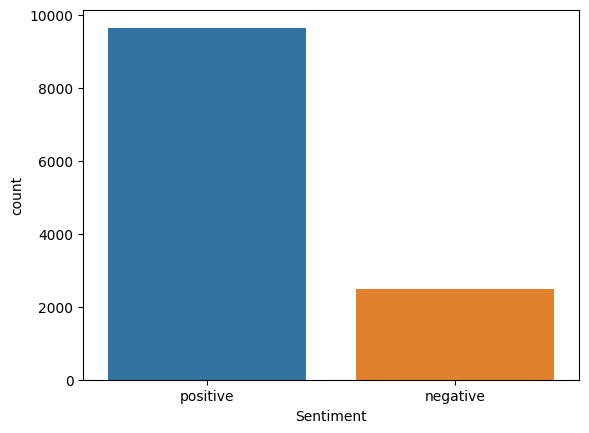

In [5]:
#distribution of positive / negative sentiments in dataset

import seaborn as sns
sns.countplot(x='Sentiment', data=data)

# Pre-processing

In [6]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [7]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    #pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    #sentence = pattern.sub('', sentence)

    return sentence

In [8]:

# Calling preprocessing_text function on Amazon_reviews
X = []
sentences = list(data['Text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:

y = data['Sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

# Train-Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("x_train shape",len(X_train))
print("x_test shape",len(X_test))
print("y_train shape",len(y_train))
print("y_test shape",len(y_test))

# The train set will be used to train our deep learning models
# while test set will be used to evaluate how well our model performs

x_train shape 9694
x_test shape 2424
y_train shape 9694
y_test shape 2424


In [11]:
# Embedding layer expects the words to be in numeric form
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer
# Method texts_to_sequences converts sentences to their numeric form

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [12]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

9281

In [13]:
# Padding all reviews to fixed length 100

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Word Embeddings using GloVe

In [14]:
# source: https://nlp.stanford.edu/projects/glove/
# Load GloVe word embeddings and create an Embeddings Dictionary

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [15]:
# Create Embedding Matrix having 100 columns
# Containing 100-dimensional GloVe word embeddings for all words in our corpus.

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [16]:
embedding_matrix.shape

(9281, 100)

# Convolutional Neural Network

In [24]:
from keras.layers import Conv1D
import keras
import numpy as np
np.random.seed(121)

In [25]:
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = {
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [ ]:
import keras
from keras.layers import Conv1D
import numpy as np
import tensorflow as tf
np.random.seed(121)
tf.random.set_seed(121)

# Neural Network architecture
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Neural Network architecture
i = 1
cnn_metric_val = {}

cnn_model_one_layer = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)


while i < 4:
  if i == 1:
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    cnn_model.add(Conv1D(128, 5, activation='relu'))
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

    # Model compiling

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())

    cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop]) #, callbacks=[early_stop]
    # Predictions on the Test Set

    #Scores
    score = cnn_model.evaluate(X_test, y_test, verbose=1)

    #Confusion Matrix
    Y_pred_prob = cnn_model.predict(X_test)

    y_pred_CNN = (Y_pred_prob > 0.5).astype(int)

    C_M = confusion_matrix(y_test, y_pred_CNN)

    Accuracy_CNN = accuracy_score(y_test, y_pred_CNN)
    Balanced_accuracy_CNN = balanced_accuracy_score(y_test, y_pred_CNN)
    Precision_CNN = precision_score(y_test, y_pred_CNN,average = 'weighted')
    Recall_CNN = recall_score(y_test, y_pred_CNN,average = 'weighted')
    F1_score_CNN = f1_score(y_test, y_pred_CNN,average = 'weighted')
    sensitivity_CNN = Recall_CNN
    specificity_CNN =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

    #Dt update
    cnn_metric_val[i] = {'Test Score:': score[0], "Test Accuracy:": score[1] \
                          , 'history_training_loss': cnn_model_history.history['loss'] , 'history_training_accuracy': cnn_model_history.history['acc'] \
                          , 'history_validation_loss': cnn_model_history.history['val_loss'],  'history_validation_accuracy': cnn_model_history.history['val_acc'] \
                          , 'y_pred_CNN': y_pred_CNN, 'True Neagative' : C_M[0][0], 'False Negative' : C_M[0][1], 'False Positive' : C_M[1][0], 'True Positive': C_M[1][1] \
                          , 'Accuracy Score' : Accuracy_CNN, 'Balanced Accuracy Score' : Balanced_accuracy_CNN, 'Precision Score' : Precision_CNN \
                          , 'Recall Score' : Recall_CNN, 'F1 Score' : F1_score_CNN, 'sensitivity_CNN' : Recall_CNN, 'specificity_CNN' : C_M[0][0] / (C_M[0][0] + C_M[0][1]) \
                          , 'Confusion Matrix' : C_M, 'CNN_model_weights' : cnn_model}
    print(f"CNN model for {i} Hidden Layer  done!")
    keras.backend.clear_session()

  if i == 2:
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    cnn_model.add(Conv1D(128, 5, activation='relu'))
    cnn_model.add(Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.0001))) #New hidden layer
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

    # Model compiling

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())

    cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop]) #, callbacks=[early_stop]
    # Predictions on the Test Set

    #Scores
    score = cnn_model.evaluate(X_test, y_test, verbose=1)

    #Confusion Matrix
    Y_pred_prob = cnn_model.predict(X_test)

    y_pred_CNN = (Y_pred_prob > 0.5).astype(int)

    C_M = confusion_matrix(y_test, y_pred_CNN)

    Accuracy_CNN = accuracy_score(y_test, y_pred_CNN)
    Balanced_accuracy_CNN = balanced_accuracy_score(y_test, y_pred_CNN)
    Precision_CNN = precision_score(y_test, y_pred_CNN,average = 'weighted')
    Recall_CNN = recall_score(y_test, y_pred_CNN,average = 'weighted')
    F1_score_CNN = f1_score(y_test, y_pred_CNN,average = 'weighted')
    sensitivity_CNN = Recall_CNN
    specificity_CNN =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

    #Dt update
    cnn_metric_val[i] = {'Test Score:': score[0], "Test Accuracy:": score[1] \
                          , 'history_training_loss': cnn_model_history.history['loss'] , 'history_training_accuracy': cnn_model_history.history['acc'] \
                          , 'history_validation_loss': cnn_model_history.history['val_loss'],  'history_validation_accuracy': cnn_model_history.history['val_acc'] \
                          , 'y_pred_CNN': y_pred_CNN, 'True Neagative' : C_M[0][0], 'False Negative' : C_M[0][1], 'False Positive' : C_M[1][0], 'True Positive': C_M[1][1] \
                          , 'Accuracy Score' : Accuracy_CNN, 'Balanced Accuracy Score' : Balanced_accuracy_CNN, 'Precision Score' : Precision_CNN \
                          , 'Recall Score' : Recall_CNN, 'F1 Score' : F1_score_CNN, 'sensitivity_CNN' : Recall_CNN, 'specificity_CNN' : C_M[0][0] / (C_M[0][0] + C_M[0][1]) \
                          , 'Confusion Matrix' : C_M, 'CNN_model_weights' : cnn_model}
    print(f"CNN model for {i} Hidden Layer  done!")
    keras.backend.clear_session()


  if i == 3:
    cnn_model = Sequential()
    cnn_model.add(embedding_layer)
    cnn_model.add(Conv1D(128, 5, activation='relu'))
    cnn_model.add(Conv1D(64, 5, activation='relu', kernel_regularizer=l2(0.0001))) #New hidden layer
    cnn_model.add(Conv1D(32, 5, activation='relu', kernel_regularizer=l2(0.0001)))  # New hidden layer
    cnn_model.add(GlobalMaxPooling1D())
    cnn_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001)))

    # Model compiling

    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(cnn_model.summary())

    cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop]) #, callbacks=[early_stop]
    # Predictions on the Test Set

    #Scores
    score = cnn_model.evaluate(X_test, y_test, verbose=1)

    #Confusion Matrix
    Y_pred_prob = cnn_model.predict(X_test)

    y_pred_CNN = (Y_pred_prob > 0.5).astype(int)

    C_M = confusion_matrix(y_test, y_pred_CNN)

    Accuracy_CNN = accuracy_score(y_test, y_pred_CNN)
    Balanced_accuracy_CNN = balanced_accuracy_score(y_test, y_pred_CNN)
    Precision_CNN = precision_score(y_test, y_pred_CNN,average = 'weighted')
    Recall_CNN = recall_score(y_test, y_pred_CNN,average = 'weighted')
    F1_score_CNN = f1_score(y_test, y_pred_CNN,average = 'weighted')
    sensitivity_CNN = Recall_CNN
    specificity_CNN =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

    #Dt update
    cnn_metric_val[i] = {'Test Score:': score[0], "Test Accuracy:": score[1] \
                          , 'history_training_loss': cnn_model_history.history['loss'] , 'history_training_accuracy': cnn_model_history.history['acc'] \
                          , 'history_validation_loss': cnn_model_history.history['val_loss'],  'history_validation_accuracy': cnn_model_history.history['val_acc'] \
                          , 'y_pred_CNN': y_pred_CNN, 'True Neagative' : C_M[0][0], 'False Negative' : C_M[0][1], 'False Positive' : C_M[1][0], 'True Positive': C_M[1][1] \
                          , 'Accuracy Score' : Accuracy_CNN, 'Balanced Accuracy Score' : Balanced_accuracy_CNN, 'Precision Score' : Precision_CNN \
                          , 'Recall Score' : Recall_CNN, 'F1 Score' : F1_score_CNN, 'sensitivity_CNN' : Recall_CNN, 'specificity_CNN' : C_M[0][0] / (C_M[0][0] + C_M[0][1]) \
                          , 'Confusion Matrix' : C_M, 'CNN_model_weights' : cnn_model}
    print(f"CNN model for {i} Hidden Layer  done!")
    keras.backend.clear_session()


  i += 1

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          928100    
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 992,357
Trainable params: 64,257
Non-trainable params: 928,100
_________________________________________________________________
None
Epoch 1/50
61/61 [==============================] - 6s 79ms/step - loss: 0.5132 - acc: 0.7470 - val_loss

In [ ]:
"""
import pickle

cnn_model.save(f"./drive/MyDrive/cnn_model_acc_{cnn_metric_val[1]['F1 Score']:.3f}.h5", save_format='h5')

file_path = '/content/drive/MyDrive/cnn_dictionary.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(cnn_metric_val, file)
"""

In [29]:
import pickle

# File path to load the dictionary from
file_path = '/content/drive/MyDrive/cnn_dictionary.pkl'

# Load the dictionary from the pickle file
with open(file_path, 'rb') as file:
    cnn_metric_val = pickle.load(file)

# Access the loaded dictionary
cnn_metric_val

{1: {'Test Score:': 0.0909065380692482,
  'Test Accuracy:': 0.9694719314575195,
  'history_training_loss': [0.5131637454032898,
   0.31262436509132385,
   0.22994600236415863,
   0.17717911303043365,
   0.13572511076927185,
   0.10634610056877136,
   0.08475235104560852,
   0.06760746240615845,
   0.05477932468056679,
   0.04558517411351204,
   0.03880706802010536,
   0.0328562967479229,
   0.02853909321129322,
   0.025463273748755455,
   0.022858213633298874,
   0.020930346101522446,
   0.01853741519153118,
   0.016921890899538994,
   0.01588873378932476,
   0.014876587316393852,
   0.014791073277592659],
  'history_training_accuracy': [0.7470019459724426,
   0.8767247200012207,
   0.9267569184303284,
   0.9513862133026123,
   0.9694390892982483,
   0.9776918292045593,
   0.985299825668335,
   0.9895551204681396,
   0.9929078221321106,
   0.9950999617576599,
   0.9958736300468445,
   0.996776282787323,
   0.9979367852210999,
   0.9978078603744507,
   0.9980657696723938,
   0.998065769

In [ ]:
cnn_metric_val[0]

76/76 [==============================] - 1s 14ms/step


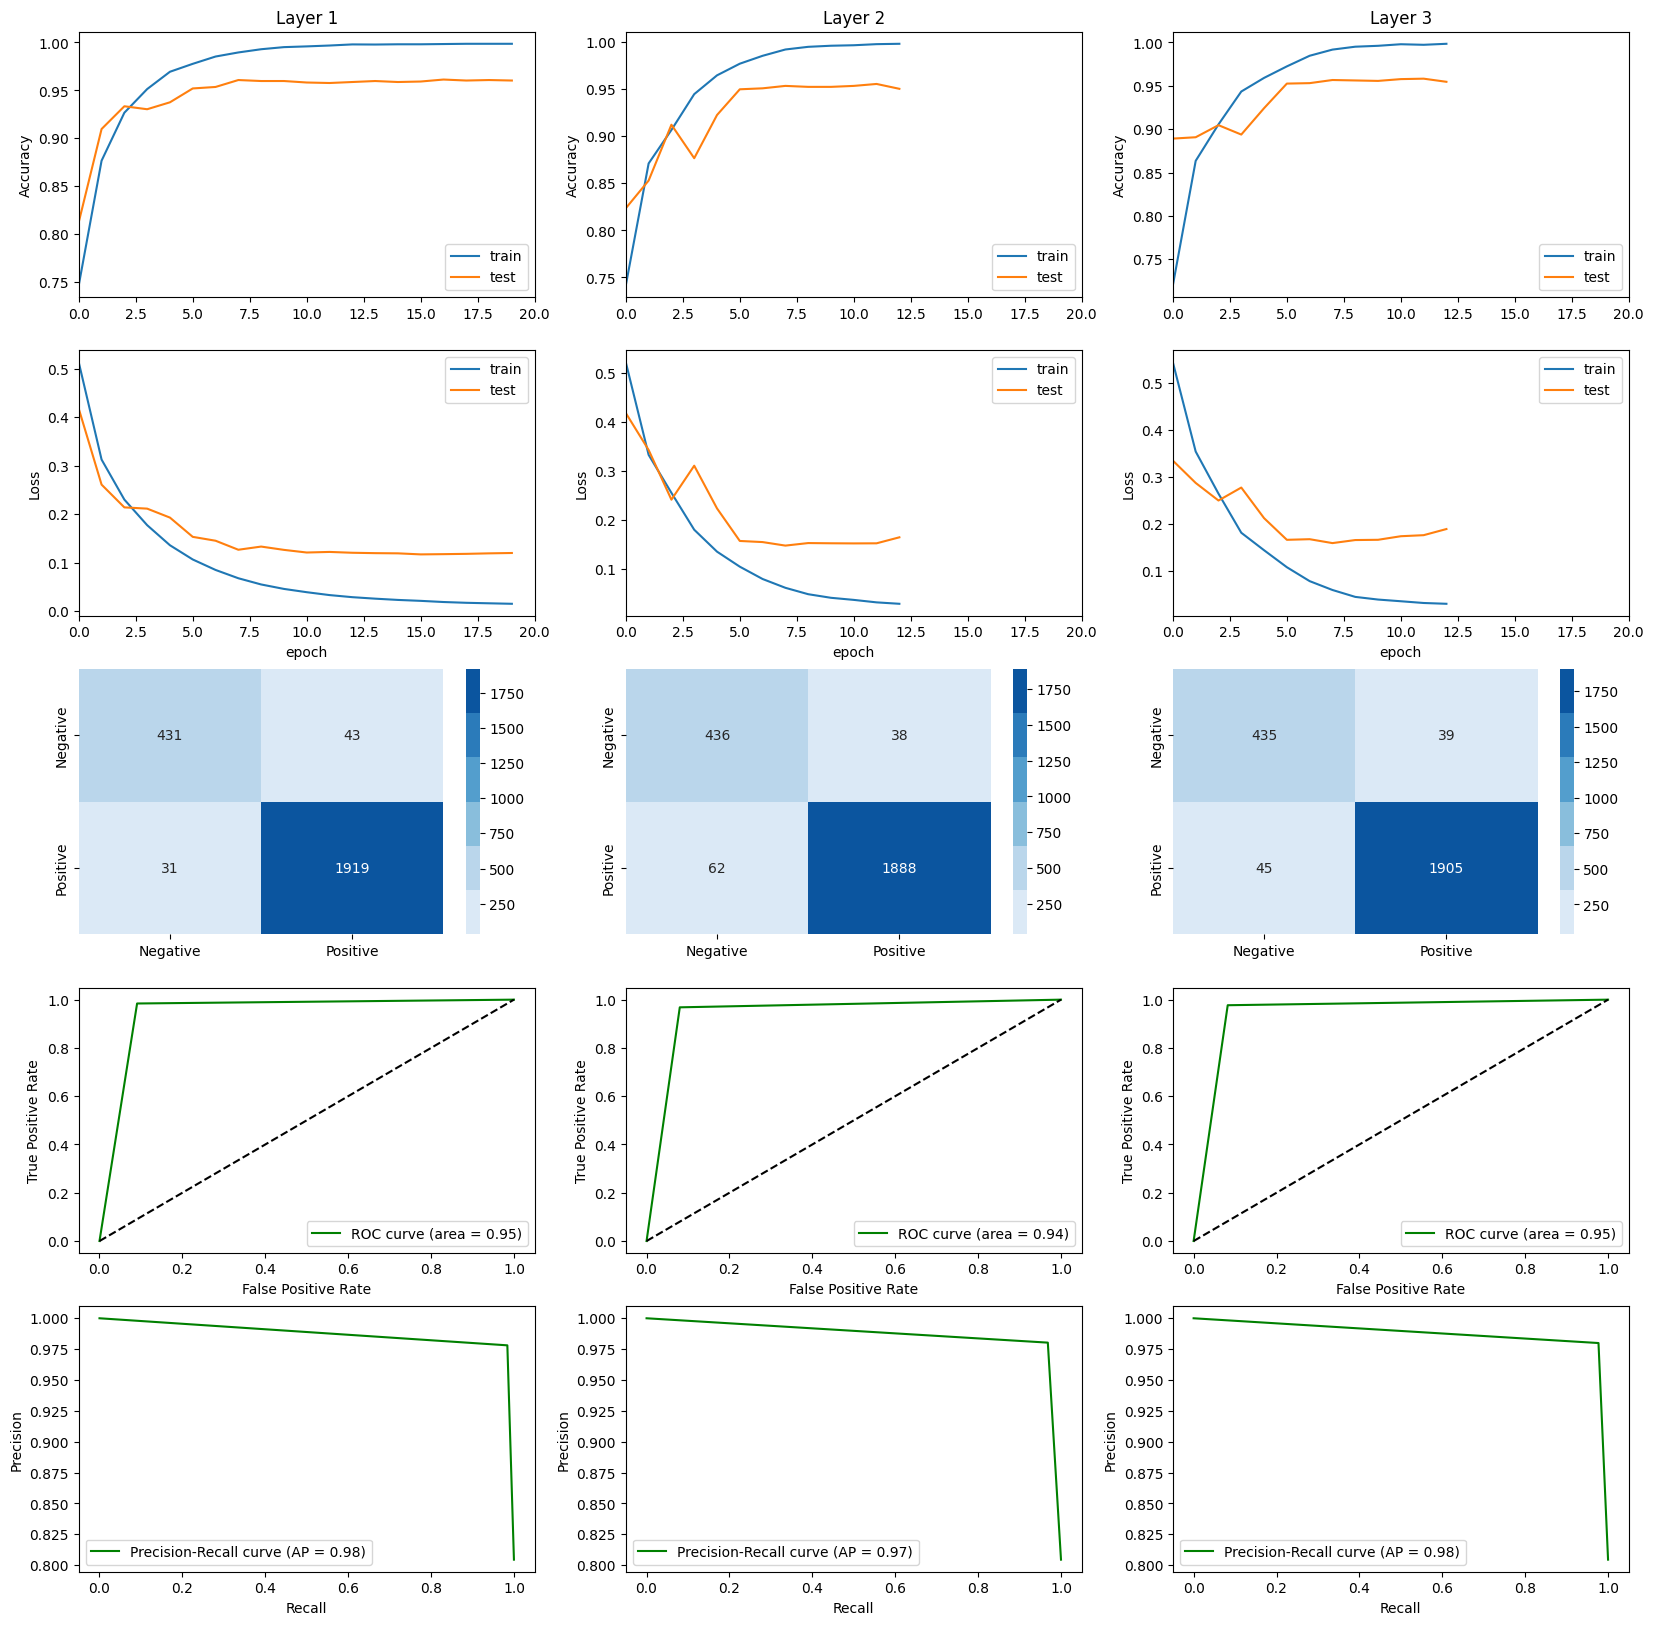

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
                         #,sharex=True, sharey=True)


#Accuracy
axes[0, 0].plot(cnn_metric_val[1]['history_training_accuracy'][:20])
axes[0, 0].plot(cnn_metric_val[1]['history_validation_accuracy'][:20])
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Layer 1')
axes[0, 0].set_xlim(0,20)
axes[0, 0].legend(['train','test'],loc='lower right')

axes[0, 1].plot(cnn_metric_val[2]['history_training_accuracy'][:20])
axes[0, 1].plot(cnn_metric_val[2]['history_validation_accuracy'][:20])
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Layer 2')
axes[0, 1].set_xlim(0,20)
axes[0, 1].legend(['train','test'],loc='lower right')

axes[0, 2].plot(cnn_metric_val[3]['history_training_accuracy'][:20])
axes[0, 2].plot(cnn_metric_val[3]['history_validation_accuracy'][:20])
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_title('Layer 3')
axes[0, 2].set_xlim(0,20)
axes[0, 2].legend(['train','test'],loc='lower right')

#Loss
axes[1, 0].plot(cnn_metric_val[1]['history_training_loss'][:20])
axes[1, 0].plot(cnn_metric_val[1]['history_validation_loss'][:20])
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('epoch')
axes[1, 0].set_xlim(0,20)
axes[1, 0].legend(['train','test'],loc='upper right')


axes[1, 1].plot(cnn_metric_val[2]['history_training_loss'][:20])
axes[1, 1].plot(cnn_metric_val[2]['history_validation_loss'][:20])
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_xlabel('epoch')
axes[1, 1].set_xlim(0,20)
axes[1, 1].legend(['train','test'],loc='upper right')


axes[1, 2].plot(cnn_metric_val[3]['history_training_loss'][:20])
axes[1, 2].plot(cnn_metric_val[3]['history_validation_loss'][:20])
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_xlabel('epoch')
axes[1, 2].set_xlim(0,20)
axes[1, 2].legend(['train','test'],loc='upper right')



#Confusion Matrix
# Define color palette
cmap = sns.color_palette("Blues")
# Define labels
labels = {0: "Negative", 1: "Positive"}

sns.heatmap(cnn_metric_val[1]['Confusion Matrix'], annot=True, fmt="d",
            xticklabels=labels.values(), yticklabels=labels.values(),
            cmap=cmap, ax=axes[2, 0])


sns.heatmap(cnn_metric_val[2]['Confusion Matrix'], annot=True, fmt="d",
            xticklabels=labels.values(), yticklabels=labels.values(),
            cmap=cmap, ax=axes[2, 1])

sns.heatmap(cnn_metric_val[3]['Confusion Matrix'], annot=True, fmt="d",
            xticklabels=labels.values(), yticklabels=labels.values(),
            cmap=cmap, ax=axes[2, 2])
#ROC curve
sns.reset_orig()

Y_pred_prob = cnn_metric_val[1]['CNN_model_weights'].predict(X_test)
y_pred_CNN = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_CNN)
roc_auc = auc(fpr, tpr)
axes[3, 0].plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
axes[3, 0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[3, 0].set_xlabel('False Positive Rate')
axes[3, 0].set_ylabel('True Positive Rate')
axes[3, 0].legend(loc='lower right')


sns.reset_orig()

Y_pred_prob = cnn_metric_val[2]['CNN_model_weights'].predict(X_test)
y_pred_CNN = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_CNN)
roc_auc = auc(fpr, tpr)
axes[3, 1].plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
axes[3, 1].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[3, 1].set_xlabel('False Positive Rate')
axes[3, 1].set_ylabel('True Positive Rate')
axes[3, 1].legend(loc='lower right')


sns.reset_orig()

Y_pred_prob = cnn_metric_val[3]['CNN_model_weights'].predict(X_test)
y_pred_CNN = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_CNN)
roc_auc = auc(fpr, tpr)
axes[3, 2].plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
axes[3, 2].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[3, 2].set_xlabel('False Positive Rate')
axes[3, 2].set_ylabel('True Positive Rate')
axes[3, 2].legend(loc='lower right')


#PR curve

#Layer 1
Y_pred_prob = cnn_metric_val[1]['CNN_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_LSTM)
avg_precision_new = average_precision_score(y_test, y_pred_LSTM)

sns.reset_orig()

axes[4, 0].plot(recall, precision, color='green', label='Precision-Recall curve (AP = %0.2f)' % avg_precision_new)
axes[4, 0].set_xlabel('Recall')
axes[4, 0].set_ylabel('Precision')
axes[4, 0].legend(loc='lower left')

#Layer 2
Y_pred_prob = cnn_metric_val[2]['CNN_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_LSTM)
avg_precision_new = average_precision_score(y_test, y_pred_LSTM)

sns.reset_orig()

axes[4, 1].plot(recall, precision, color='green', label='Precision-Recall curve (AP = %0.2f)' % avg_precision_new)
axes[4, 1].set_xlabel('Recall')
axes[4, 1].set_ylabel('Precision')
axes[4, 1].legend(loc='lower left')


#Layer 3
Y_pred_prob = cnn_metric_val[3]['CNN_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_LSTM)
avg_precision_new = average_precision_score(y_test, y_pred_LSTM)

sns.reset_orig()

axes[4, 2].plot(recall, precision, color='green', label='Precision-Recall curve (AP = %0.2f)' % avg_precision_new)
axes[4, 2].set_xlabel('Recall')
axes[4, 2].set_ylabel('Precision')
axes[4, 2].legend(loc='lower left')




plt.savefig("/content/CNN 3 layer overview_TrainingData.png",dpi = 300, bbox_inches='tight')


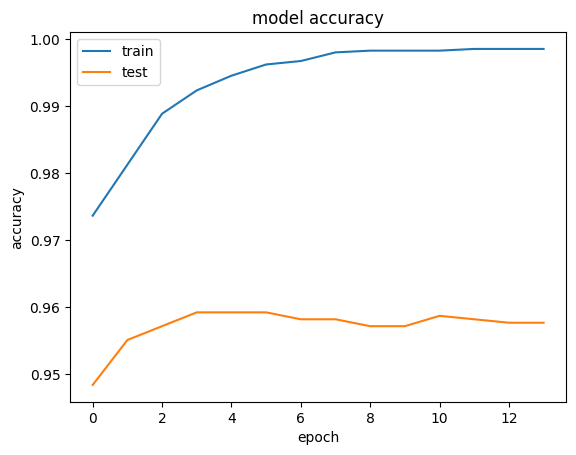

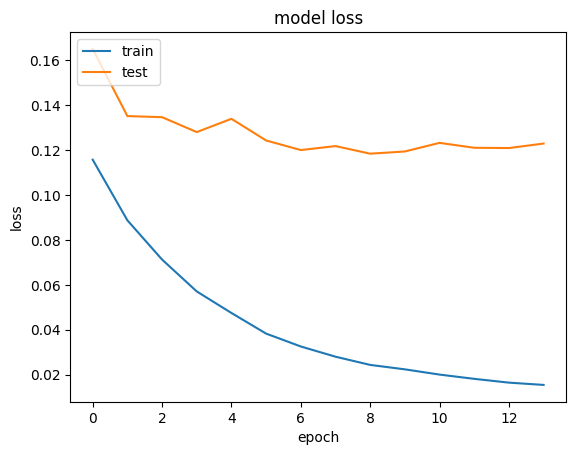

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt
sns.reset_orig()

plt.plot(cnn_model_history_one_layer.history['acc'])
plt.plot(cnn_model_history_one_layer.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history_one_layer.history['loss'])
plt.plot(cnn_model_history_one_layer.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
#Loading CNN one layer history

with open('/trainHistoryDict', "rb") as file_pi:
    cnn_history_one_layer = pickle.load(file_pi)

cnn_history_one_layer_dt = np.array(cnn_history_one_layer)

np.save('cnn_history_one_layer_dt.npy',cnn_history_one_layer_dt)

!cp '/content/cnn_history_one_layer_dt.npy' '/content/drive/MyDrive/cnn_history_one_layer_dt.npy'


In [ ]:
# Saving the model as a h5 file for possible use later
cnn_model.save(f"./drive/MyDrive/cnn_model_acc_{round(score[1], 3)}_one_layer.h5", save_format='h5')

In [ ]:
#Loading cnn_model with best weights
from tensorflow.keras.models import load_model

cnn_model = load_model('/content/drive/MyDrive/c1_cnn_model_acc_0.97.h5')

# Recurrent Neural Network (LSTM)


In [30]:
from keras.layers import LSTM
import numpy as np
np.random.seed(121)

In [31]:
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Model Training

#lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights, callbacks=[early_stop])

In [ ]:
import keras
from keras.layers import LSTM
import numpy as np
import tensorflow as tf
np.random.seed(121)
tf.random.set_seed(121)

# Neural Network architecture
lr = 5e-5
optimizer = Adam(learning_rate=lr)

# Class weights
class_weights = { # Newly added
    0: 2.45, # Class 0 has the fewest samples, so we weight it higher
    1: 0.63   # Class 1 has the most samples, so we weight it lower}
}

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

#return_sequences=True in the first LSTM layer, the output of the layer will have a shape of (batch_size, timesteps, units).
# Neural Network architecture
i = 1
lstm_metric_val = {}

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)


while i < 4:

  if i == 1:
    lstm_model = Sequential()
    lstm_model.add(embedding_layer)
    lstm_model.add(LSTM(64))
    lstm_model.add(Dense(1))

    # Model compiling

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(lstm_model.summary())

    lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights) #, callbacks=[early_stop]
    # Predictions on the Test Set

    #Scores
    score = lstm_model.evaluate(X_test, y_test, verbose=1)

    #Confusion Matrix
    Y_pred_prob = lstm_model.predict(X_test)

    y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)

    C_M = confusion_matrix(y_test, y_pred_LSTM)

    Accuracy_LSTM = accuracy_score(y_test, y_pred_LSTM)
    Balanced_accuracy_LSTM = balanced_accuracy_score(y_test, y_pred_LSTM)
    Precision_LSTM = precision_score(y_test, y_pred_LSTM,average = 'weighted')
    Recall_LSTM = recall_score(y_test, y_pred_LSTM,average = 'weighted')
    F1_score_LSTM = f1_score(y_test, y_pred_LSTM,average = 'weighted')
    sensitivity_LSTM = Recall_LSTM
    specificity_LSTM =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

    #Dt update
    lstm_metric_val[i] = {'Test Score:': score[0], "Test Accuracy:": score[1] \
                          , 'history_training_loss': lstm_model_history.history['loss'] , 'history_training_accuracy': lstm_model_history.history['acc'] \
                          , 'history_validation_loss': lstm_model_history.history['val_loss'],  'history_validation_accuracy': lstm_model_history.history['val_acc'] \
                          , 'True Neagative' : C_M[0][0], 'False Negative' : C_M[0][1], 'False Positive' : C_M[1][0], 'True Positive': C_M[1][1] \
                          , 'Accuracy Score' : Accuracy_LSTM, 'Balanced Accuracy Score' : Balanced_accuracy_LSTM, 'Precision Score' : Precision_LSTM \
                          , 'Recall Score' : Recall_LSTM, 'F1 Score' : F1_score_LSTM, 'sensitivity_LSTM' : Recall_LSTM, 'specificity_LSTM' : C_M[0][0] / (C_M[0][0] + C_M[0][1]) \
                          , 'Confusion Matrix' : C_M, 'LSTM_model_weights' : lstm_model}
    print(f"LSTM model for {i} Hidden Layer  done!")
    keras.backend.clear_session()

  if i == 2:
    lstm_model = Sequential()
    lstm_model.add(embedding_layer)
    lstm_model.add(LSTM(64, return_sequences=True))
    lstm_model.add(LSTM(32))
    lstm_model.add(Dense(1, activation='sigmoid'))

    # Model compiling

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(lstm_model.summary())

    lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights) #, callbacks=[early_stop]
   # Predictions on the Test Set

    #Scores
    score = lstm_model.evaluate(X_test, y_test, verbose=1)

    #Confusion Matrix
    Y_pred_prob = lstm_model.predict(X_test)

    y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)

    C_M = confusion_matrix(y_test, y_pred_LSTM)

    Accuracy_LSTM = accuracy_score(y_test, y_pred_LSTM)
    Balanced_accuracy_LSTM = balanced_accuracy_score(y_test, y_pred_LSTM)
    Precision_LSTM = precision_score(y_test, y_pred_LSTM,average = 'weighted')
    Recall_LSTM = recall_score(y_test, y_pred_LSTM,average = 'weighted')
    F1_score_LSTM = f1_score(y_test, y_pred_LSTM,average = 'weighted')
    sensitivity_LSTM = Recall_LSTM
    specificity_LSTM =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

    #Dt update
    lstm_metric_val[i] = {'Test Score:': score[0], "Test Accuracy:": score[1] \
                          , 'history_training_loss': lstm_model_history.history['loss'] , 'history_training_accuracy': lstm_model_history.history['acc'] \
                          , 'history_validation_loss': lstm_model_history.history['val_loss'],  'history_validation_accuracy': lstm_model_history.history['val_acc'] \
                          , 'True Negative' : C_M[0][0], 'False Negative' : C_M[0][1], 'False Positive' : C_M[1][0], 'True Positive': C_M[1][1] \
                          , 'Accuracy Score' : Accuracy_LSTM, 'Balanced Accuracy Score' : Balanced_accuracy_LSTM, 'Precision Score' : Precision_LSTM \
                          , 'Recall Score' : Recall_LSTM, 'F1 Score' : F1_score_LSTM, 'sensitivity_LSTM' : Recall_LSTM, 'specificity_LSTM' : C_M[0][0] / (C_M[0][0] + C_M[0][1])\
                          , 'Confusion Matrix' : C_M, 'LSTM_model_weights' : lstm_model}
    print(f"LSTM model for {i} Hidden Layer  done!")
    keras.backend.clear_session()


  if i == 3:
    lstm_model = Sequential()
    lstm_model.add(embedding_layer)
    lstm_model.add(LSTM(64, return_sequences=True))
    lstm_model.add(LSTM(32, return_sequences=True))
    lstm_model.add(LSTM(16, activation='tanh'))
    lstm_model.add(Dense(1, activation='sigmoid'))

    # Model compiling

    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    print(lstm_model.summary())

    lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=40, verbose=1, validation_split=0.2,class_weight=class_weights) #, callbacks=[early_stop]
    # Predictions on the Test Set

    #Scores
    score = lstm_model.evaluate(X_test, y_test, verbose=1)

    #Confusion Matrix
    Y_pred_prob = lstm_model.predict(X_test)

    y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)

    C_M = confusion_matrix(y_test, y_pred_LSTM)

    Accuracy_LSTM = accuracy_score(y_test, y_pred_LSTM)
    Balanced_accuracy_LSTM = balanced_accuracy_score(y_test, y_pred_LSTM)
    Precision_LSTM = precision_score(y_test, y_pred_LSTM,average = 'weighted')
    Recall_LSTM = recall_score(y_test, y_pred_LSTM,average = 'weighted')
    F1_score_LSTM = f1_score(y_test, y_pred_LSTM,average = 'weighted')
    sensitivity_LSTM = Recall_LSTM
    specificity_LSTM =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

    #Dt update
    lstm_metric_val[i] = {'Test Score:': score[0], "Test Accuracy:": score[1] \
                          , 'history_training_loss': lstm_model_history.history['loss'] , 'history_training_accuracy': lstm_model_history.history['acc'] \
                          , 'history_validation_loss': lstm_model_history.history['val_loss'],  'history_validation_accuracy': lstm_model_history.history['val_acc'] \
                          , 'True Neagative' : C_M[0][0], 'False Negative' : C_M[0][1], 'False Positive' : C_M[1][0], 'True Positive': C_M[1][1] \
                          , 'Accuracy Score' : Accuracy_LSTM, 'Balanced Accuracy Score' : Balanced_accuracy_LSTM, 'Precision Score' : Precision_LSTM \
                          , 'Recall Score' : Recall_LSTM, 'F1 Score' : F1_score_LSTM, 'sensitivity_LSTM' : Recall_LSTM, 'specificity_LSTM' : C_M[0][0] / (C_M[0][0] + C_M[0][1])\
                          , 'Confusion Matrix' : C_M, 'LSTM_model_weights' : lstm_model}
    print(f"LSTM model for {i} Hidden Layer  done!")
    #keras.backend.clear_session()


  i += 1

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          928100    
                                                                 
 lstm_5 (LSTM)               (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 970,405
Trainable params: 42,305
Non-trainable params: 928,100
_________________________________________________________________
None
Epoch 1/40
61/61 [==============================] - 12s 162ms/step - loss: 1.4079 - acc: 0.2560 - val_loss: 0.9867 - val_acc: 0.2135
Epoch 2/40
61/61 [==============================] - 9s 149ms/step - loss: 0.6341 - acc: 0.6842 - val_loss: 0.4547 - val_acc: 0.8406
Epoch 3/40
61/61 [===================

In [ ]:
import pickle

file_path = '/content/drive/MyDrive/LSTM_dictionary.pkl'

with open(file_path, 'wb') as file:
    pickle.dump(lstm_metric_val, file)

In [32]:
import pickle

# File path to load the dictionary from
file_path = '/content/drive/MyDrive/LSTM_dictionary.pkl'

# Load the dictionary from the pickle file
with open(file_path, 'rb') as file:
    lstm_metric_val = pickle.load(file)

# Access the loaded dictionary
print(lstm_metric_val)

{1: {'Test Score:': 0.6510217189788818, 'Test Accuracy:': 0.8721122145652771, 'history_training_loss': [1.4078514575958252, 0.6341358423233032, 0.6561539173126221, 0.518357515335083, 0.5069636106491089, 0.44649752974510193, 0.8213492035865784, 0.6815879940986633, 0.6778770089149475, 0.6742249131202698, 0.6692224144935608, 0.6633944511413574, 0.6561793684959412, 0.6467354893684387, 0.5866683721542358, 0.468703031539917, 0.44175195693969727, 0.3966328799724579, 0.3937057852745056, 0.452741414308548, 0.367656946182251, 0.5418494343757629, 0.35598674416542053, 0.30419889092445374, 0.31903770565986633, 0.296371728181839, 1.9969944953918457, 7.2663421630859375, 5.585793495178223, 0.6865522861480713, 0.6768007874488831, 0.6745935678482056, 0.6740530133247375, 0.6721080541610718, 0.6705785989761353, 0.6704014539718628, 0.6679373979568481, 0.6652196645736694, 0.6631433963775635, 0.6539404392242432], 'history_training_accuracy': [0.25596389174461365, 0.6842037439346313, 0.6135396361351013, 0.790

76/76 [==============================] - 4s 51ms/step


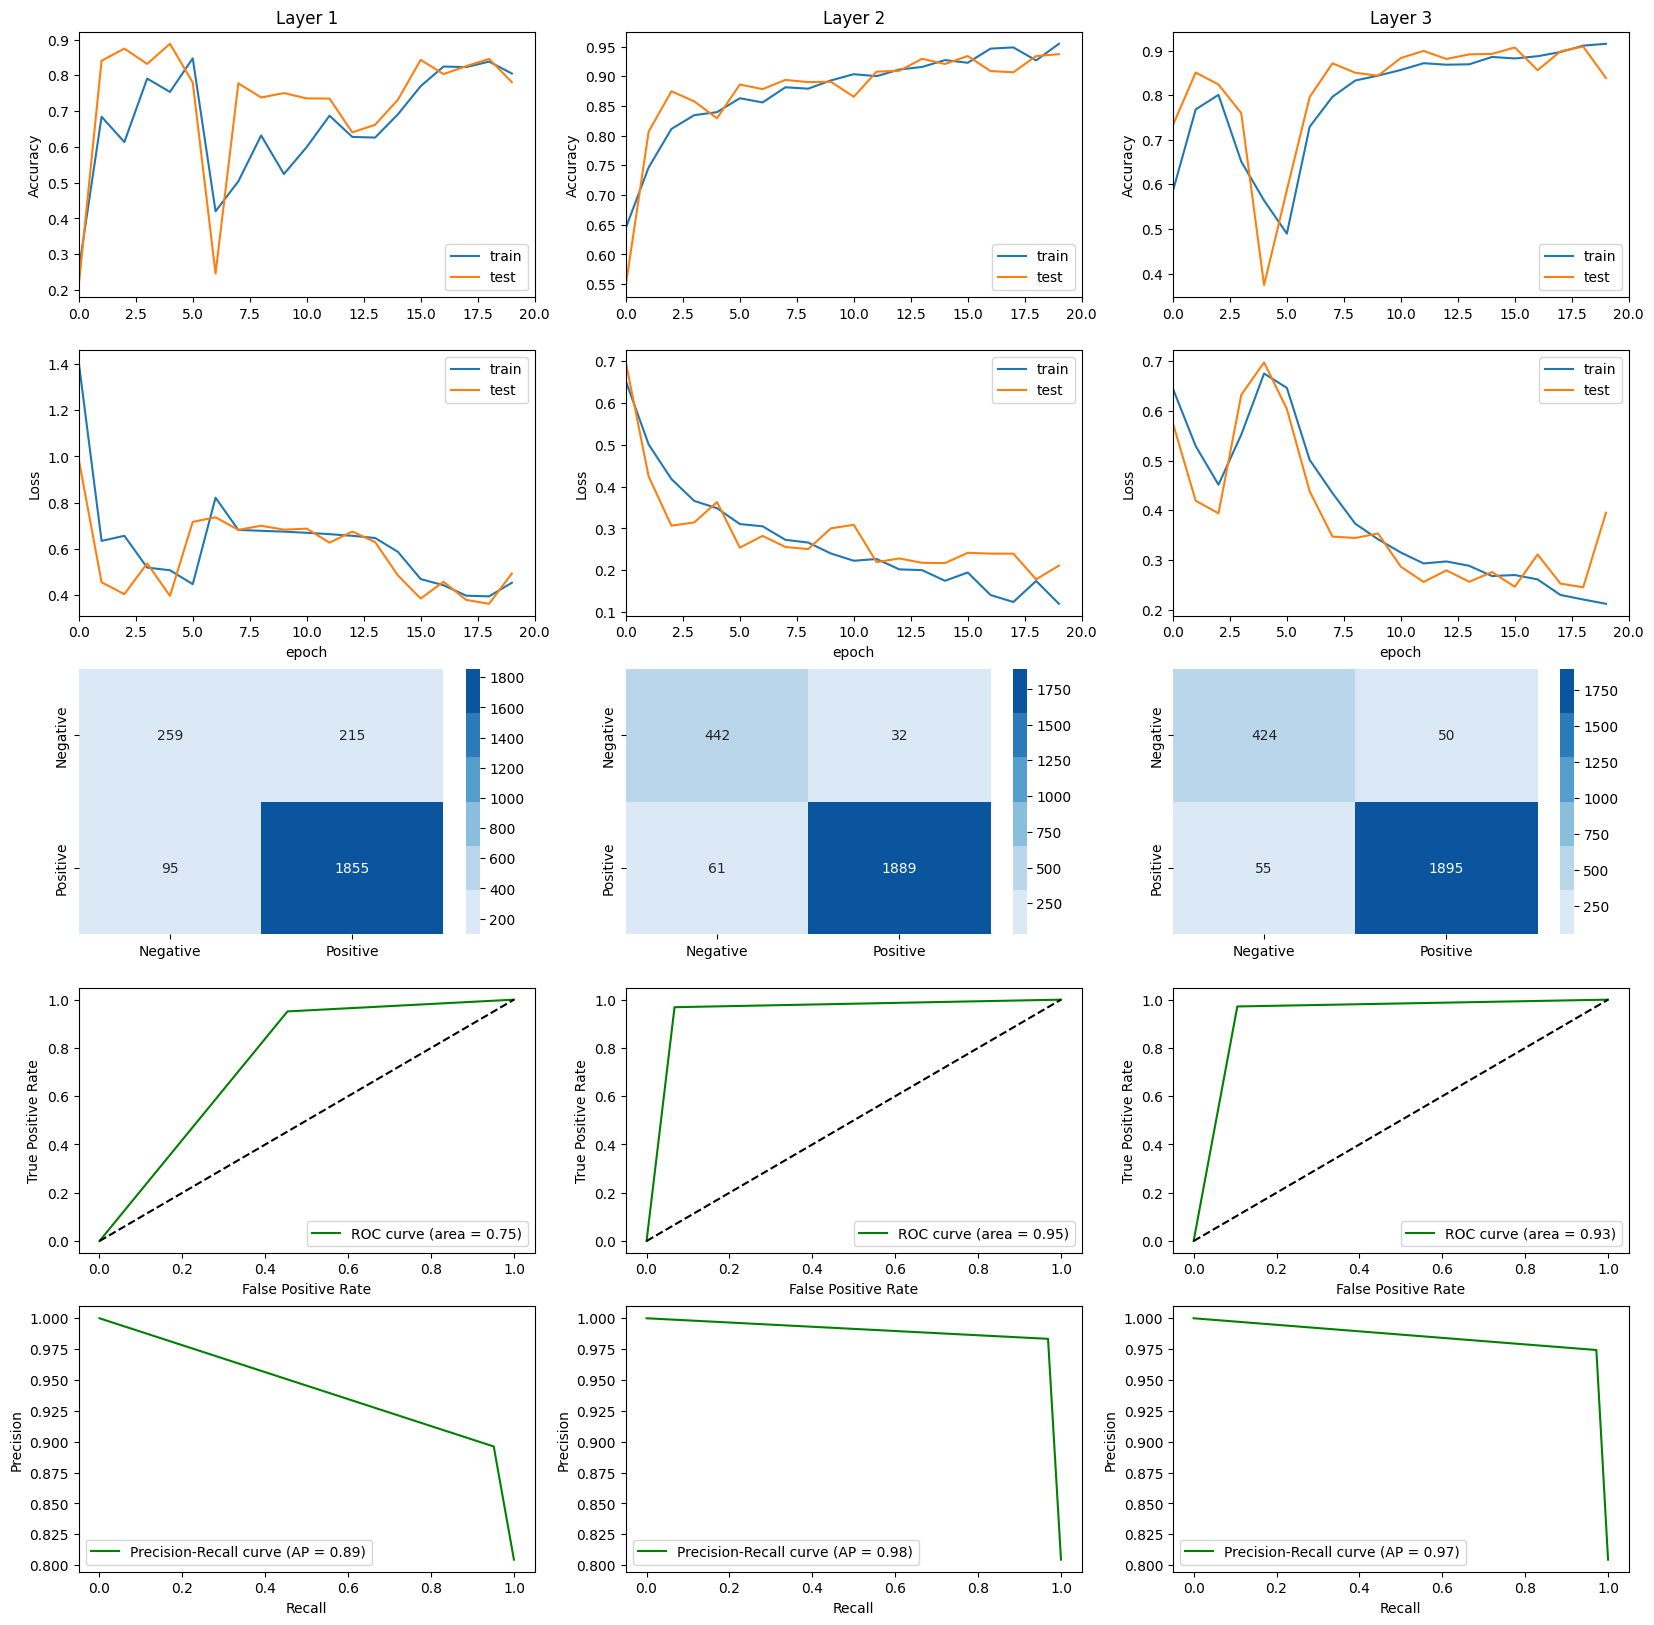

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
                         #,sharex=True, sharey=True)
#lstm_metric_val[1]['history_training_accuracy']
#lstm_metric_val[1]['history_validation_accuracy']

#Accuracy
axes[0, 0].plot(lstm_metric_val[1]['history_training_accuracy'][:20])
axes[0, 0].plot(lstm_metric_val[1]['history_validation_accuracy'][:20])
axes[0, 0].set_ylabel('Accuracy')
#axes[0, 0].set_xlabel('epoch')
axes[0, 0].set_title('Layer 1')
axes[0, 0].set_xlim(0,20)
axes[0, 0].legend(['train','test'],loc='lower right')

axes[0, 1].plot(lstm_metric_val[2]['history_training_accuracy'][:20])
axes[0, 1].plot(lstm_metric_val[2]['history_validation_accuracy'][:20])
axes[0, 1].set_ylabel('Accuracy')
#axes[0, 1].set_xlabel('epoch')
axes[0, 1].set_title('Layer 2')
axes[0, 1].set_xlim(0,20)
axes[0, 1].legend(['train','test'],loc='lower right')

axes[0, 2].plot(lstm_metric_val[3]['history_training_accuracy'][:20])
axes[0, 2].plot(lstm_metric_val[3]['history_validation_accuracy'][:20])
axes[0, 2].set_ylabel('Accuracy')
#axes[0, 2].set_xlabel('epoch')
axes[0, 2].set_title('Layer 3')
axes[0, 2].set_xlim(0,20)
axes[0, 2].legend(['train','test'],loc='lower right')

#Loss
axes[1, 0].plot(lstm_metric_val[1]['history_training_loss'][:20])
axes[1, 0].plot(lstm_metric_val[1]['history_validation_loss'][:20])
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('epoch')
#axes[1, 0].set_title('Layer 1')
axes[1, 0].set_xlim(0,20)
axes[1, 0].legend(['train','test'],loc='upper right')


axes[1, 1].plot(lstm_metric_val[2]['history_training_loss'][:20])
axes[1, 1].plot(lstm_metric_val[2]['history_validation_loss'][:20])
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_xlabel('epoch')
#axes[1, 1].set_title('Layer 2')
axes[1, 1].set_xlim(0,20)
axes[1, 1].legend(['train','test'],loc='upper right')


axes[1, 2].plot(lstm_metric_val[3]['history_training_loss'][:20])
axes[1, 2].plot(lstm_metric_val[3]['history_validation_loss'][:20])
axes[1, 2].set_ylabel('Loss')
axes[1, 2].set_xlabel('epoch')
#axes[1, 2].set_title('Layer 3')
axes[1, 2].set_xlim(0,20)
axes[1, 2].legend(['train','test'],loc='upper right')



#Confusion Matrix
# Define color palette
cmap = sns.color_palette("Blues")
# Define labels
labels = {0: "Negative", 1: "Positive"}

sns.heatmap(lstm_metric_val[1]['Confusion Matrix'], annot=True, fmt="d",
            xticklabels=labels.values(), yticklabels=labels.values(),
            cmap=cmap, ax=axes[2, 0])


sns.heatmap(lstm_metric_val[2]['Confusion Matrix'], annot=True, fmt="d",
            xticklabels=labels.values(), yticklabels=labels.values(),
            cmap=cmap, ax=axes[2, 1])

sns.heatmap(lstm_metric_val[3]['Confusion Matrix'], annot=True, fmt="d",
            xticklabels=labels.values(), yticklabels=labels.values(),
            cmap=cmap, ax=axes[2, 2])
#ROC curve
sns.reset_orig()

Y_pred_prob = lstm_metric_val[1]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_LSTM)
roc_auc = auc(fpr, tpr)
axes[3, 0].plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
axes[3, 0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[3, 0].set_xlabel('False Positive Rate')
axes[3, 0].set_ylabel('True Positive Rate')
axes[3, 0].legend(loc='lower right')


sns.reset_orig()

Y_pred_prob = lstm_metric_val[2]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_LSTM)
roc_auc = auc(fpr, tpr)
axes[3, 1].plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
axes[3, 1].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[3, 1].set_xlabel('False Positive Rate')
axes[3, 1].set_ylabel('True Positive Rate')
axes[3, 1].legend(loc='lower right')


sns.reset_orig()

Y_pred_prob = lstm_metric_val[3]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_LSTM)
roc_auc = auc(fpr, tpr)
axes[3, 2].plot(fpr, tpr, color='green', label='ROC curve (area = %0.2f)' % roc_auc)
axes[3, 2].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[3, 2].set_xlabel('False Positive Rate')
axes[3, 2].set_ylabel('True Positive Rate')
axes[3, 2].legend(loc='lower right')


#PR curve

#Layer 1
Y_pred_prob = lstm_metric_val[1]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_LSTM)
avg_precision_new = average_precision_score(y_test, y_pred_LSTM)

sns.reset_orig()

axes[4, 0].plot(recall, precision, color='green', label='Precision-Recall curve (AP = %0.2f)' % avg_precision_new)
axes[4, 0].set_xlabel('Recall')
axes[4, 0].set_ylabel('Precision')
#plt.title('Precision-Recall Curve - LSTM Model Performance on Training Data')
axes[4, 0].legend(loc='lower left')

#Layer 2
Y_pred_prob = lstm_metric_val[2]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_LSTM)
avg_precision_new = average_precision_score(y_test, y_pred_LSTM)

sns.reset_orig()

axes[4, 1].plot(recall, precision, color='green', label='Precision-Recall curve (AP = %0.2f)' % avg_precision_new)
axes[4, 1].set_xlabel('Recall')
axes[4, 1].set_ylabel('Precision')
#plt.title('Precision-Recall Curve - LSTM Model Performance on Training Data')
axes[4, 1].legend(loc='lower left')


#Layer 3
Y_pred_prob = lstm_metric_val[3]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_LSTM)
avg_precision_new = average_precision_score(y_test, y_pred_LSTM)

sns.reset_orig()

axes[4, 2].plot(recall, precision, color='green', label='Precision-Recall curve (AP = %0.2f)' % avg_precision_new)
axes[4, 2].set_xlabel('Recall')
axes[4, 2].set_ylabel('Precision')
#plt.title('Precision-Recall Curve - LSTM Model Performance on Training Data')
axes[4, 2].legend(loc='lower left')

#plt.subplots_adjust(hspace=0.5)

#plt.show()

plt.savefig("/content/LSTM 3 layer overview_TrainingData.png",dpi = 300, bbox_inches='tight')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_LSTM = accuracy_score(y_test, y_pred_LSTM)
Balanced_accuracy_LSTM = balanced_accuracy_score(y_test, y_pred_LSTM)
Precision_LSTM = precision_score(y_test, y_pred_LSTM,average = 'weighted')
Recall_LSTM = recall_score(y_test, y_pred_LSTM,average = 'weighted')
F1_score_LSTM = f1_score(y_test, y_pred_LSTM,average = 'weighted')
sensitivity_LSTM = Recall_LSTM
specificity_LSTM =  C_M[0][0] / (C_M[0][0] + C_M[0][1])


print(Accuracy_LSTM)
print(Balanced_accuracy_LSTM)
print(Precision_LSTM)
print(Recall_LSTM)
print(F1_score_LSTM)
print(sensitivity_LSTM)
print(specificity_LSTM)

0.9624587458745875
0.9383414475819539
0.9623202722662944
0.9624587458745875
0.9623832538437331
0.9624587458745875
0.8987341772151899


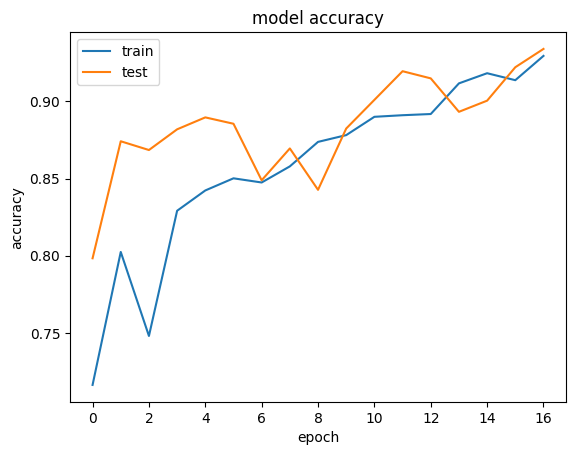

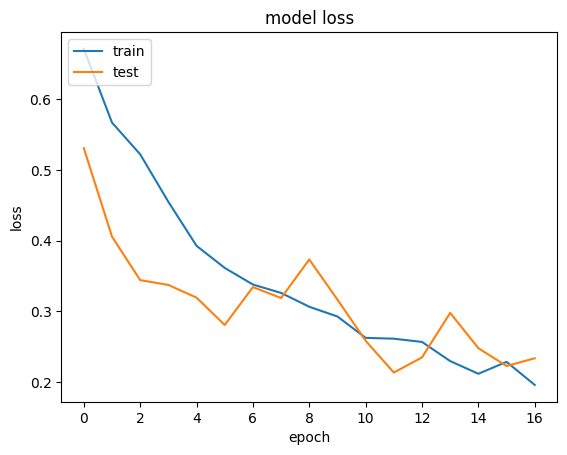

In [ ]:
sns.reset_orig()
# Model Performance Charts
import seaborn as sn
import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()


In [ ]:
# Saving the model as a h5 file for possible use later
lstm_model.save(f"./drive/MyDrive/lstm_model_acc_{round(score[1], 3)}_HiddenLayer_3.h5", save_format='h5')

# BERT

In [29]:
# Install specific libraries
! pip install transformers
! pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [31]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

data['label'] = data['Sentiment'].apply(lambda x: 1 if x=="positive" else 0)

# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['Text'], data['label'],
                                                                    random_state=121,
                                                                    test_size=0.3,
                                                                    stratify=data['Sentiment'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=121,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Majority of titles above have word length under 200.
MAX_LENGHT = 200
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [33]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 16                                             #define a batch size  changed from 10

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [34]:
class BertClassifier(nn.Module):
    def __init__(self, bert):
      super(BertClassifier, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x
    """
    def generate_text(self, input_ids, attention_mask, max_length):
        # Generate summary text using the model
        outputs = self.bert.generate(input_ids, attention_mask=attention_mask, max_length=max_length)
        generated_text = self.bert.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated_text
    """
model = BertClassifier(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr = 2e-5)          # learning rate, changed from 1e-5,5e-5
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 4

# Class weights
class_weights = {0: 2.45, 1: 0.62}

In [35]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_correct  = 0, 0
  total_samples = 0
  val_accuracy = []
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    class_weights                                               # update class weights
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU
    predicted_labels = torch.from_numpy(np.argmax(preds, axis=1))
    predicted_labels_tensor = torch.tensor(predicted_labels)  # Convert to PyTorch tensor
    total_correct += (predicted_labels_tensor == labels).sum().item()
    total_samples += labels.size(0)
  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
  avg_accuracy = total_correct / total_samples
  return avg_loss , avg_accuracy                                     # returns the loss & accuracy of predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_correct = 0, 0
  total_samples = 0
  val_accuracy = []
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      _, predicted_labels = torch.max(preds, 1)
      total_correct += (predicted_labels == labels).sum().item()
      #total_correct += np.sum(preds == labels.cpu().numpy())  # convert labels to NumPy array using cpu()
      total_samples += labels.size(0)
      # Calculate the accuracy rate
      #accuracy = (preds == labels).cpu().numpy().mean() * 100
      #val_accuracy.append(accuracy)
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  avg_accuracy = total_correct / total_samples
  #avg_accuracy = np.mean(val_accuracy)

  return avg_loss , avg_accuracy

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]
best_valid_accuracy = float('inf')
train_accuracies = []  # empty lists to store training and validation accuracy of each epoch
valid_accuracies = []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, train_accuracy = train()  # train model
    #train_loss  = train()  # train model
    valid_loss, valid_accuracy = evaluate()  # evaluate model
    if valid_loss < best_valid_loss :              # save the best model
        best_valid_loss = valid_loss
        best_valid_accuracy = valid_accuracies
        torch.save(model.state_dict(), 'Bert_new_model_weights_h3_7.pt')
    train_losses.append(train_loss)  # append training and validation loss
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)  # append training and validation accuracy
    valid_accuracies.append(valid_accuracy)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Validation Accuracy: {valid_accuracy:.3f}')


 Epoch 1 / 4
  Batch    50  of    531.
  Batch   100  of    531.
  Batch   150  of    531.
  Batch   200  of    531.
  Batch   250  of    531.
  Batch   300  of    531.
  Batch   350  of    531.
  Batch   400  of    531.
  Batch   450  of    531.
  Batch   500  of    531.

Evaluating...
  Batch    50  of    114.
  Batch   100  of    114.

Training Loss: 0.216
Training Accuracy: 0.924
Validation Loss: 0.131
Validation Accuracy: 0.964

 Epoch 2 / 4
  Batch    50  of    531.
  Batch   100  of    531.
  Batch   150  of    531.
  Batch   200  of    531.
  Batch   250  of    531.
  Batch   300  of    531.
  Batch   350  of    531.
  Batch   400  of    531.
  Batch   450  of    531.
  Batch   500  of    531.

Evaluating...
  Batch    50  of    114.
  Batch   100  of    114.

Training Loss: 0.086
Training Accuracy: 0.978
Validation Loss: 0.107
Validation Accuracy: 0.972

 Epoch 3 / 4
  Batch    50  of    531.
  Batch   100  of    531.
  Batch   150  of    531.
  Batch   200  of    531.
  Batc

In [ ]:
!cp '/content/Bert_new_model_weights_h3_7.pt' '/content/drive/MyDrive/Bert_new_model_weights_h3_7.pt'

In [ ]:
h3_7_dt =  {'train_losses':train_losses,'valid_losses':valid_losses,'train_accuracies':train_accuracies,'valid_accuracies':valid_accuracies}

h3_7_metric = np.array(h3_7_dt)

np.save('h3_7_metric.npy',h3_7_metric)

!cp '/content/h3_7_metric.npy' '/content/drive/MyDrive/h3_7_metric.npy'


In [36]:
# load weights of best model
path = '/content/drive/MyDrive/Bert_new_model_weights_h3_1.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [26]:
h3_7_metric = np.load('/content/drive/MyDrive/h3_7_metric.npy', allow_pickle=True) #2e-5 , 16, 4

h3_5_metric = np.load('/content/drive/MyDrive/h3_5_metric.npy', allow_pickle=True) #2e-5 , 32, 4

h3_4_metric = np.load('/content/drive/MyDrive/h3_4_metric.npy', allow_pickle=True) #5e-5 , 16, 4

h3_3_metric = np.load('/content/drive/MyDrive/h3_3_metric.npy', allow_pickle=True) #5e-5 , 32, 4



In [25]:
#Actual
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds_BERT = np.argmax(preds, axis = 1)

acc = accuracy_score(test_y, preds_BERT)

print(classification_report(test_y, preds_BERT, target_names=['Negative', 'Positive']))

print('test_accuracy: %.3f' % (acc))

              precision    recall  f1-score   support

    Negative       0.92      0.95      0.94       371
    Positive       0.99      0.98      0.98      1447

    accuracy                           0.97      1818
   macro avg       0.95      0.97      0.96      1818
weighted avg       0.97      0.97      0.97      1818

test_accuracy: 0.973


In [ ]:
#Frozen
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds_BERT_frozen = np.argmax(preds, axis = 1)

acc = accuracy_score(test_y, preds_BERT_frozen)

print(classification_report(test_y, preds_BERT_frozen, target_names=['Negative', 'Positive']))

print('test_accuracy: %.3f' % (acc))

              precision    recall  f1-score   support

    Negative       0.84      0.34      0.49       371
    Positive       0.85      0.98      0.91      1447

    accuracy                           0.85      1818
   macro avg       0.84      0.66      0.70      1818
weighted avg       0.85      0.85      0.83      1818

test_accuracy: 0.852


In [ ]:
#Un-frozen
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

with torch.no_grad():
  preds_unfrozen = model(test_seq, test_mask)
  preds_unfrozen = preds_unfrozen.detach().cpu().numpy()

preds_BERT_unfrozen = np.argmax(preds_unfrozen, axis = 1)

acc = accuracy_score(test_y, preds_BERT_unfrozen)

print(classification_report(test_y, preds_BERT_unfrozen, target_names=['Negative', 'Positive']))

print('test_accuracy: %.3f' % (acc))

              precision    recall  f1-score   support

    Negative       0.93      0.97      0.95       371
    Positive       0.99      0.98      0.99      1447

    accuracy                           0.98      1818
   macro avg       0.96      0.98      0.97      1818
weighted avg       0.98      0.98      0.98      1818

test_accuracy: 0.979


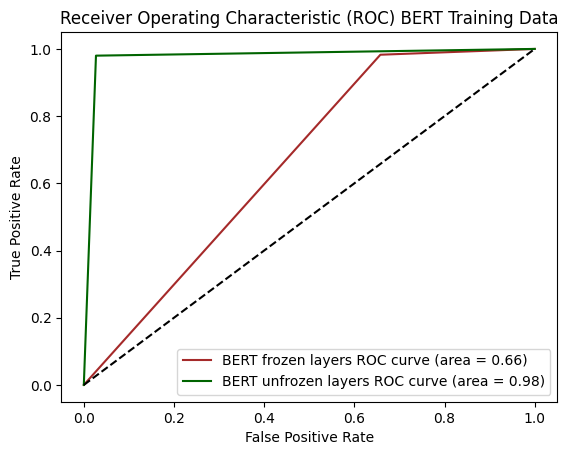

In [ ]:
#Frozen
sns.reset_orig()

#preds_BERT = np.argmax(preds, axis = 1)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(test_y, preds_BERT)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr_unf, tpr_unf, thresholds_unf = roc_curve(test_y, preds_BERT_unfrozen)


# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Compute the area under the ROC curve (AUC)
roc_auc_unf = auc(fpr_unf, tpr_unf)


# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='brown', label='BERT frozen layers ROC curve (area = %0.2f)' % roc_auc)
plt.plot(fpr_unf, tpr_unf, color='darkgreen', label='BERT unfrozen layers ROC curve (area = %0.2f)' % roc_auc_unf)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) BERT Training Data')
plt.legend(loc='lower right')
#plt.show()

#plt.savefig("Receiver Operating Characteristic (ROC)_training.png", bbox_inches='tight')


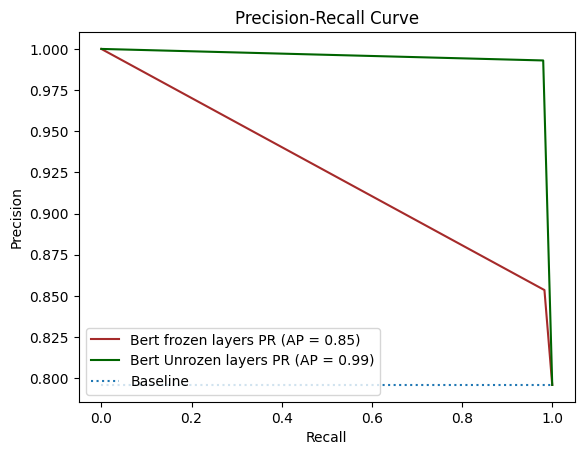

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(test_y, preds_BERT)

avg_precision = average_precision_score(test_y, preds_BERT)

precision_unf, recall_unf, thresholds_unf = precision_recall_curve(test_y, preds_BERT_unfrozen)

avg_precision_unf = average_precision_score(test_y, preds_BERT_unfrozen)

sns.reset_orig()

baseline = len(test_y[test_y==1]) / len(test_y)

plt.figure()
plt.plot(recall, precision, color='brown', label='Bert frozen layers PR (AP = %0.2f)' % avg_precision)
plt.plot(recall_unf, precision_unf, color='darkgreen', label='Bert Unrozen layers PR (AP = %0.2f)' % avg_precision_unf)
plt.plot([0, 1], [baseline, baseline], linestyle='dotted', label='Baseline')



plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
#plt.show()

#plt.savefig("Precision-Recall Curve_training.png", bbox_inches='tight')

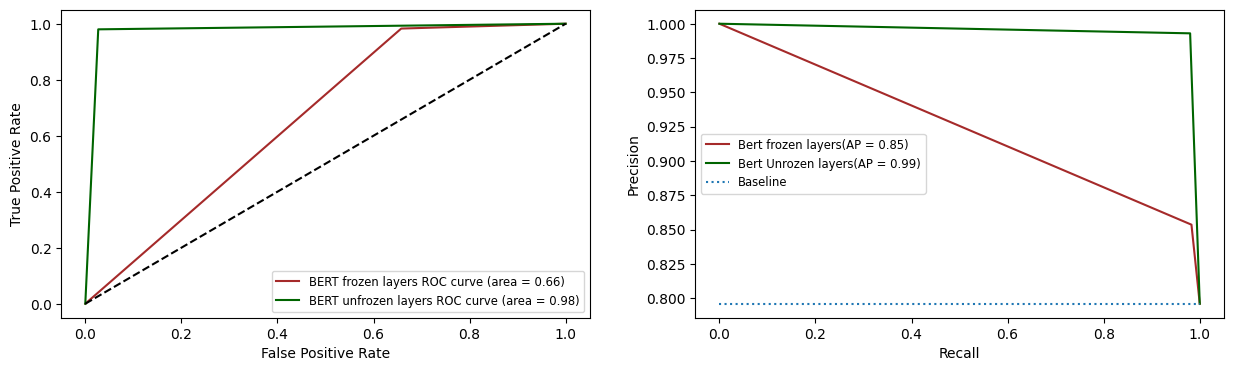

In [ ]:
#Frozen
sns.reset_orig()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

#preds_BERT = np.argmax(preds, axis = 1)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(test_y, preds_BERT)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr_unf, tpr_unf, thresholds_unf = roc_curve(test_y, preds_BERT_unfrozen)


# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Compute the area under the ROC curve (AUC)
roc_auc_unf = auc(fpr_unf, tpr_unf)


# Plot the ROC curve
axes[0].plot(fpr, tpr, color='brown', label='BERT frozen layers ROC curve (area = %0.2f)' % roc_auc)
axes[0].plot(fpr_unf, tpr_unf, color='darkgreen', label='BERT unfrozen layers ROC curve (area = %0.2f)' % roc_auc_unf)
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
#axes[0]..title('Receiver Operating Characteristic (ROC) BERT Training Data')
axes[0].legend(loc='best', fontsize='small')
#plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(test_y, preds_BERT)

avg_precision = average_precision_score(test_y, preds_BERT)

precision_unf, recall_unf, thresholds_unf = precision_recall_curve(test_y, preds_BERT_unfrozen)

avg_precision_unf = average_precision_score(test_y, preds_BERT_unfrozen)

sns.reset_orig()

baseline = len(test_y[test_y==1]) / len(test_y)


axes[1].plot(recall, precision, color='brown', label='Bert frozen layers(AP = %0.2f)' % avg_precision)
axes[1].plot(recall_unf, precision_unf, color='darkgreen', label='Bert Unrozen layers(AP = %0.2f)' % avg_precision_unf)
axes[1].plot([0, 1], [baseline, baseline], linestyle='dotted', label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
#axes[1].title('Precision-Recall Curve')
axes[1].legend(loc='best', fontsize='small')
#plt.show()

plt.savefig("BERT Frozen_Unfrozen Training Data.png", bbox_inches='tight')


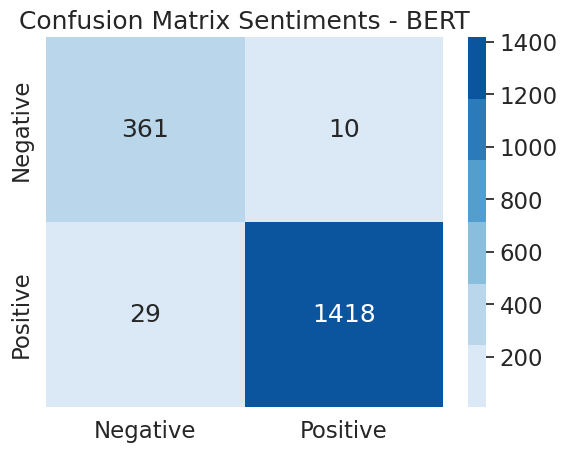

In [ ]:
#h3_1_unfrozen
C_M = confusion_matrix(test_y, preds_BERT)

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

plt.savefig("confusion_matrix_TrainingData_BERT.png", bbox_inches='tight')


Text(0.5, 1.0, 'Confusion Matrix Sentiments - BERT')

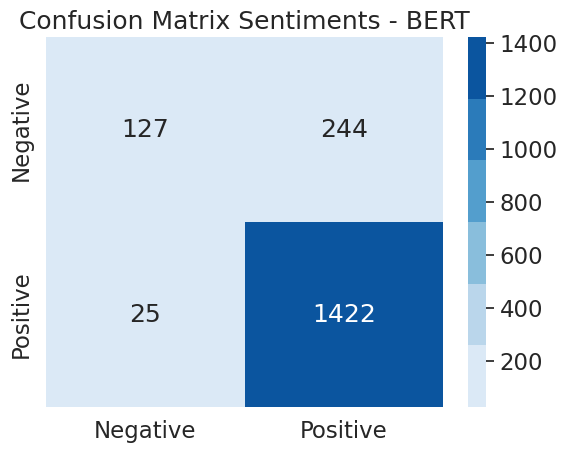

In [ ]:
#h2_frozen
C_M = confusion_matrix(test_y, preds_BERT)

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

#plt.savefig("confusion_matrix_TrainingData_BERT.png", bbox_inches='tight')


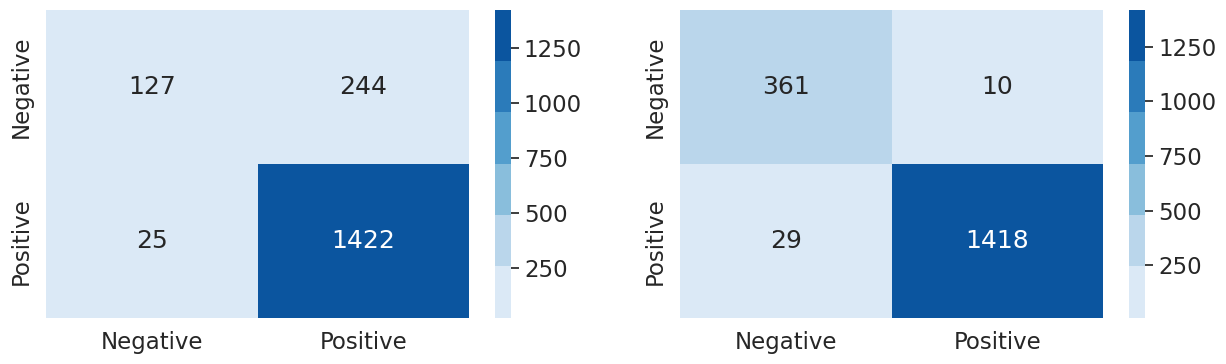

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

#h2_frozen
C_M = confusion_matrix(test_y, preds_BERT)

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap,ax=axes[0])
#ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

#h3_1_unfrozen
C_M_unf = confusion_matrix(test_y, preds_BERT_unfrozen)


# Plot confusion matrix
sns.set(font_scale=1.5)
sns.heatmap(C_M_unf, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap,ax=axes[1])
#ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

#plt.savefig("confusion_matrix_TrainingData_BERT.png", bbox_inches='tight')


plt.savefig("confusion_matrix_TrainingData_BERT Frozen_vs_Unfrozen.png", bbox_inches='tight')


In [ ]:
#h3_7
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_BERT = accuracy_score(test_y, preds_BERT)
Balanced_accuracy_BERT = balanced_accuracy_score(test_y, preds_BERT)
Precision_BERT = precision_score(test_y, preds_BERT,average = 'weighted')
Recall_BERT = recall_score(test_y, preds_BERT,average = 'weighted')
F1_score_BERT = f1_score(test_y, preds_BERT,average = 'weighted') #, average='macro'
sensitivity_BERT = Recall_BERT
specificity_BERT =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

print(Accuracy_BERT)
print(Balanced_accuracy_BERT)
print(Precision_BERT)
print(Recall_BERT)
print(F1_score_BERT)
print(sensitivity_BERT)
print(specificity_BERT)


0.9785478547854786
0.9765021785011092
0.9792517971900617
0.9785478547854786
0.9787447688835615
0.9785478547854786
0.9730458221024259


In [47]:
#h3_3_metric.item()['valid_losses']
h3_3_metric.item()['valid_accuracies']

[0.9790979097909791, 0.977997799779978, 0.9801980198019802, 0.9801980198019802]

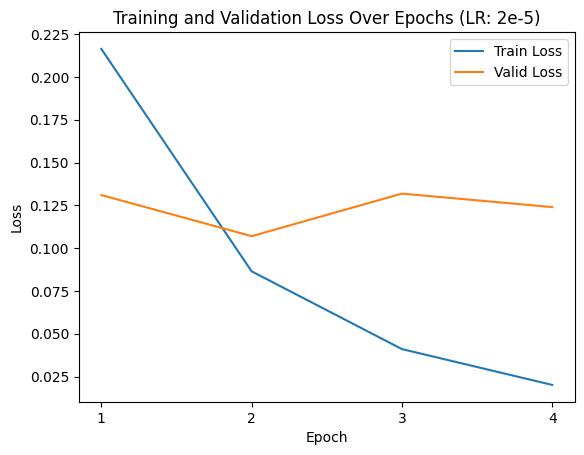

In [ ]:
import matplotlib.pyplot as plt

train_losses = h3_7_metric.item()['train_losses']
valid_losses = h3_7_metric.item()['valid_losses']

x_axis = list(range(1, len(train_losses) + 1))
plt.plot(x_axis, train_losses, label='Train Loss')
plt.plot(x_axis, valid_losses, label='Valid Loss')
plt.xticks(x_axis)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(' Loss with LR: 2e-5, Batch size of 16')
plt.legend()
plt.show()


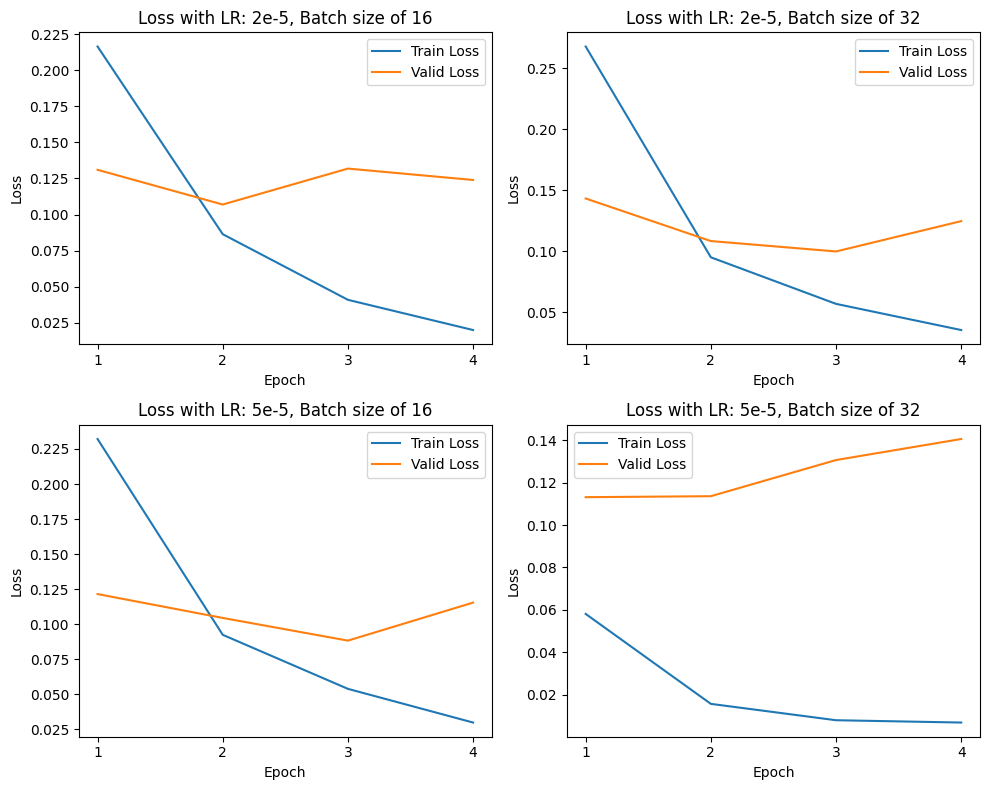

In [41]:
import matplotlib.pyplot as plt

# Data for h3_7_metric
h3_7_train_losses = h3_7_metric.item()['train_losses']
h3_7_valid_losses = h3_7_metric.item()['valid_losses']

# Data for h3_5_metric
h3_5_train_losses = h3_5_metric.item()['train_losses']
h3_5_valid_losses = h3_5_metric.item()['valid_losses']

# Data for h3_4_metric
h3_4_train_losses = h3_4_metric.item()['train_losses']
h3_4_valid_losses = h3_4_metric.item()['valid_losses']

# Data for h3_3_metric
h3_3_train_losses = h3_3_metric.item()['train_losses']
h3_3_valid_losses = h3_3_metric.item()['valid_losses']

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

x_axis = list(range(1, len(h3_7_train_losses) + 1))
# Plot for h3_7_metric
axs[0, 0].plot(x_axis, h3_7_train_losses, label='Train Loss')
axs[0, 0].plot(x_axis, h3_7_valid_losses, label='Valid Loss')
axs[0, 0].set_xticks(x_axis)
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss with LR: 2e-5, Batch size of 16')
axs[0, 0].legend()

# Plot for h3_5_metric
axs[0, 1].plot(x_axis, h3_5_train_losses, label='Train Loss')
axs[0, 1].plot(x_axis, h3_5_valid_losses, label='Valid Loss')
axs[0, 1].set_xticks(x_axis)
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Loss with LR: 2e-5, Batch size of 32')
axs[0, 1].legend()

# Plot for h3_4_metric
axs[1, 0].plot(x_axis, h3_4_train_losses, label='Train Loss')
axs[1, 0].plot(x_axis, h3_4_valid_losses, label='Valid Loss')
axs[1, 0].set_xticks(x_axis)
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_title('Loss with LR: 5e-5, Batch size of 16')
axs[1, 0].legend()

# Plot for h3_3_metric
axs[1, 1].plot(x_axis, h3_3_train_losses, label='Train Loss')
axs[1, 1].plot(x_axis, h3_3_valid_losses, label='Valid Loss')
axs[1, 1].set_xticks(x_axis)
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_title('Loss with LR: 5e-5, Batch size of 32')
axs[1, 1].legend()

# Adjusting the spacing between subplots
plt.tight_layout()

# Display the plots
#plt.show()

plt.savefig('BERT tuning.png',dpi=300)

In [43]:
h3_7_metric

array({'train_losses': [0.21634293867717103, 0.08646765415904879, 0.04104287975262535, 0.02012177647490242], 'valid_losses': [0.13101312183374703, 0.10698786913008805, 0.13185782762057466, 0.12398188281395849], 'train_accuracies': [0.9244282008960151, 0.9779533128979014, 0.9903324687573686, 0.995873614713511], 'valid_accuracies': [0.9636963696369637, 0.9724972497249725, 0.9763476347634763, 0.9774477447744775]},
      dtype=object)

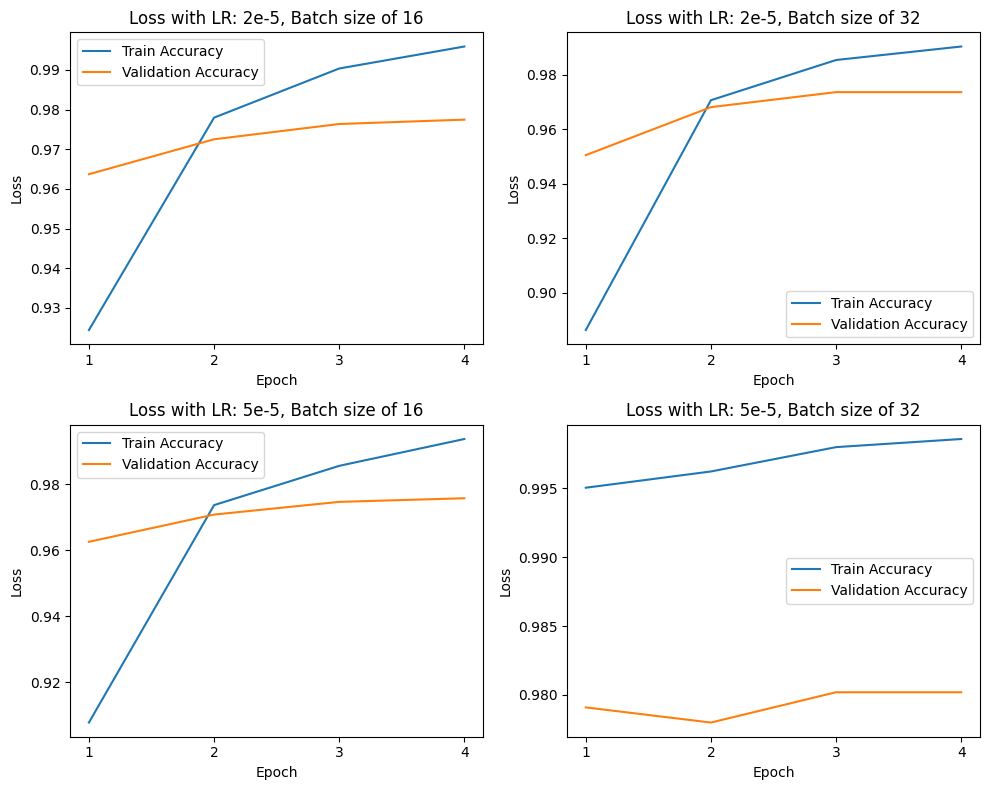

In [45]:
import matplotlib.pyplot as plt

# Data for h3_7_metric
h3_7_train_losses = h3_7_metric.item()['train_accuracies']
h3_7_valid_losses = h3_7_metric.item()['valid_accuracies']

# Data for h3_5_metric
h3_5_train_losses = h3_5_metric.item()['train_accuracies']
h3_5_valid_losses = h3_5_metric.item()['valid_accuracies']

# Data for h3_4_metric
h3_4_train_losses = h3_4_metric.item()['train_accuracies']
h3_4_valid_losses = h3_4_metric.item()['valid_accuracies']

# Data for h3_3_metric
h3_3_train_losses = h3_3_metric.item()['train_accuracies']
h3_3_valid_losses = h3_3_metric.item()['valid_accuracies']

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

x_axis = list(range(1, len(h3_7_train_losses) + 1))
# Plot for h3_7_metric
axs[0, 0].plot(x_axis, h3_7_train_losses, label='Train Accuracy')
axs[0, 0].plot(x_axis, h3_7_valid_losses, label='Validation Accuracy')
axs[0, 0].set_xticks(x_axis)
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_title('Loss with LR: 2e-5, Batch size of 16')
axs[0, 0].legend()

# Plot for h3_5_metric
axs[0, 1].plot(x_axis, h3_5_train_losses, label='Train Accuracy')
axs[0, 1].plot(x_axis, h3_5_valid_losses, label='Validation Accuracy')
axs[0, 1].set_xticks(x_axis)
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_title('Loss with LR: 2e-5, Batch size of 32')
axs[0, 1].legend()

# Plot for h3_4_metric
axs[1, 0].plot(x_axis, h3_4_train_losses, label='Train Accuracy')
axs[1, 0].plot(x_axis, h3_4_valid_losses, label='Validation Accuracy')
axs[1, 0].set_xticks(x_axis)
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].set_title('Loss with LR: 5e-5, Batch size of 16')
axs[1, 0].legend()

# Plot for h3_3_metric
axs[1, 1].plot(x_axis, h3_3_train_losses, label='Train Accuracy')
axs[1, 1].plot(x_axis, h3_3_valid_losses, label='Validation Accuracy')
axs[1, 1].set_xticks(x_axis)
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_title('Loss with LR: 5e-5, Batch size of 32')
axs[1, 1].legend()

# Adjusting the spacing between subplots
plt.tight_layout()

# Display the plots
#plt.show()

plt.savefig('BERT tuning_Accuracy.png',dpi=300)

# All 3 on Training Data

76/76 [==============================] - 1s 10ms/step


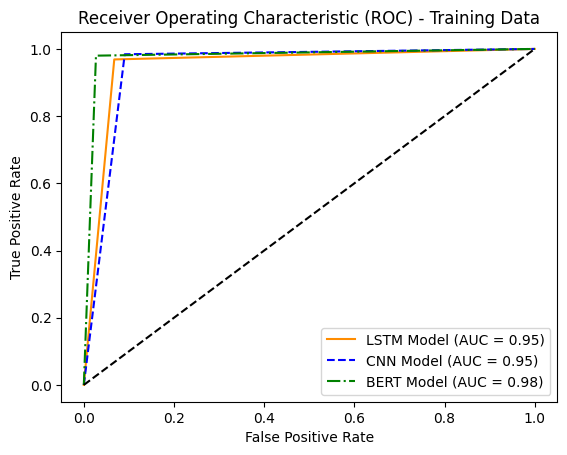

In [ ]:
sns.reset_orig()
# Compute the false positive rate (FPR) and true positive rate (TPR) for LSTM model
Y_pred_prob = lstm_metric_val[2]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_LSTM)

fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_LSTM)

# Compute the false positive rate (FPR) and true positive rate (TPR) for CNN model
Y_pred_prob = cnn_metric_val[1]['CNN_model_weights'].predict(X_test)
y_pred_CNN = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_CNN)

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_CNN)

# Compute the false positive rate (FPR) and true positive rate (TPR) for BERT model
fpr_bert, tpr_bert, thresholds_bert = roc_curve(test_y, preds_BERT)


# Compute the area under the ROC curve (AUC) for LSTM model
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_bert = auc(fpr_bert, tpr_bert)


# Plot the ROC curves
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', linestyle='-' , label='LSTM Model (AUC = %0.2f)' % roc_auc_lstm)
plt.plot(fpr_cnn, tpr_cnn, color='blue', linestyle='--' , label='CNN Model (AUC = %0.2f)' % roc_auc_cnn)
plt.plot(fpr_bert, tpr_bert, color='green', linestyle='-.' , label='BERT Model (AUC = %0.2f)' % roc_auc_bert)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc='lower right')
#plt.show()


plt.savefig("ROC Curve - All Model Performance on Training Data.png", bbox_inches='tight')


In [ ]:
sns.reset_orig()
# Compute the false positive rate (FPR) and true positive rate (TPR) for LSTM model
Y_pred_prob = lstm_metric_val[2]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_LSTM)

fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_LSTM)

# Compute the false positive rate (FPR) and true positive rate (TPR) for CNN model
Y_pred_prob = cnn_metric_val[1]['CNN_model_weights'].predict(X_test)
y_pred_CNN = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_CNN)

fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_CNN)

# Compute the false positive rate (FPR) and true positive rate (TPR) for BERT model
fpr_bert, tpr_bert, thresholds_bert = roc_curve(test_y, preds_BERT)


# Compute the area under the ROC curve (AUC) for LSTM model
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_bert = auc(fpr_bert, tpr_bert)


# Plot the ROC curves
plt.figure()
plt.plot(fpr_lstm, tpr_lstm, color='darkorange', linestyle='-' , label='LSTM Model (AUC = %0.2f)' % roc_auc_lstm)
plt.plot(fpr_cnn, tpr_cnn, color='blue', linestyle='-' , label='CNN Model (AUC = %0.2f)' % roc_auc_cnn)
plt.plot(fpr_bert, tpr_bert, color='green', linestyle='-' , label='BERT Model (AUC = %0.2f)' % roc_auc_bert)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Training Data')
plt.legend(loc='lower right')
#plt.show()


#plt.savefig("ROC Curve - All Model Performance on Training Data.png", bbox_inches='tight')


76/76 [==============================] - 0s 2ms/step


NameError: ignored

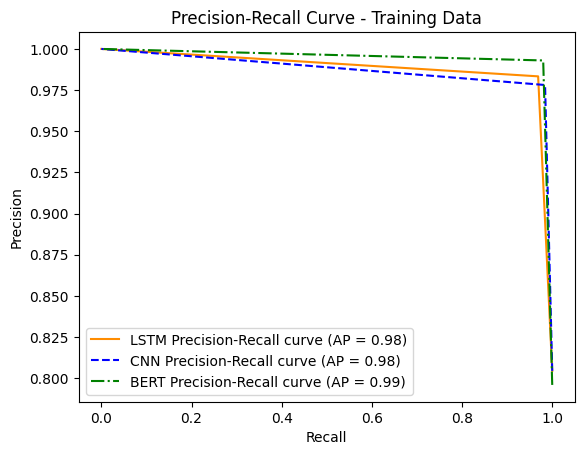

In [ ]:
sns.reset_orig()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(y_test, y_pred_LSTM)

avg_precision_lstm = average_precision_score(y_test, y_pred_LSTM)

precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(y_test, y_pred_CNN)

avg_precision_cnn = average_precision_score(y_test, y_pred_CNN)


precision_bert, recall_bert, thresholds_bert = precision_recall_curve(test_y, preds_BERT)

avg_precision_bert = average_precision_score(test_y, preds_BERT)


plt.figure()
plt.plot(recall_lstm, precision_lstm, color='darkorange', linestyle='-' , label='LSTM Precision-Recall curve (AP = %0.2f)' % avg_precision_lstm)
plt.plot(recall_cnn, precision_cnn, color='blue', linestyle='--' , label='CNN Precision-Recall curve (AP = %0.2f)' % avg_precision_cnn)
plt.plot(recall_bert, precision_bert, color='green', linestyle='-.' , label='BERT Precision-Recall curve (AP = %0.2f)' % avg_precision_bert)


#plt.plot([0, 1], [1, 0], color='navy', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Training Data')
plt.legend(loc='lower left')
#plt.show()

plt.savefig("Precision-Recall Curve - All Model Performance on Training Data.png", bbox_inches='tight')

76/76 [==============================] - 0s 3ms/step


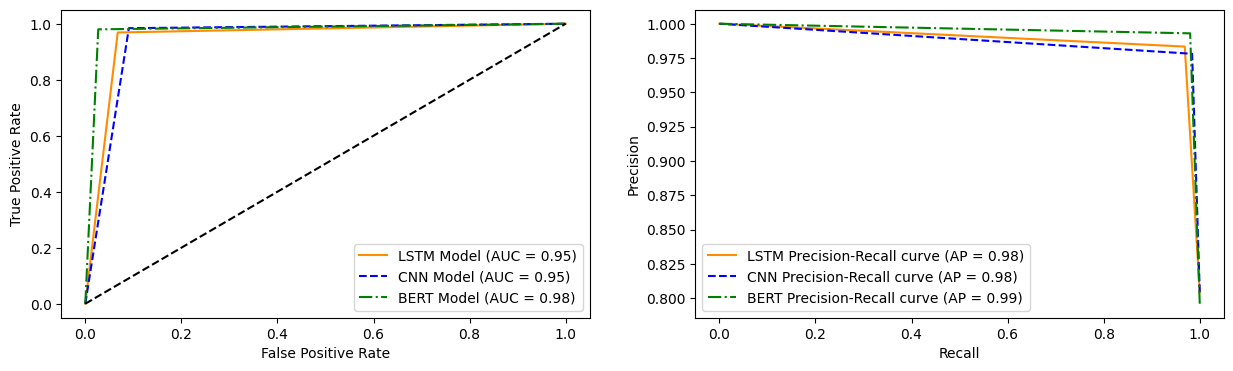

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.reset_orig()

# Compute the false positive rate (FPR) and true positive rate (TPR) for LSTM model
Y_pred_prob = loaded_dict[2]['LSTM_model_weights'].predict(X_test)
y_pred_LSTM = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_LSTM)

fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_LSTM)

# Compute the false positive rate (FPR) and true positive rate (TPR) for CNN model
Y_pred_prob = cnn_loaded_dict[1]['CNN_model_weights'].predict(X_test)
y_pred_CNN = (Y_pred_prob > 0.5).astype(int)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_CNN)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_CNN)

# Compute the false positive rate (FPR) and true positive rate (TPR) for BERT model
fpr_bert, tpr_bert, thresholds_bert = roc_curve(test_y, preds_BERT)


# Compute the area under the ROC curve (AUC) for LSTM model
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_bert = auc(fpr_bert, tpr_bert)

sns.reset_orig()

# Plot the ROC curves
axes[0].plot(fpr_lstm, tpr_lstm, color='darkorange', linestyle='-' , label='LSTM Model (AUC = %0.2f)' % roc_auc_lstm)
axes[0].plot(fpr_cnn, tpr_cnn, color='blue', linestyle='--' , label='CNN Model (AUC = %0.2f)' % roc_auc_cnn)
axes[0].plot(fpr_bert, tpr_bert, color='green', linestyle='-.' , label='BERT Model (AUC = %0.2f)' % roc_auc_bert)
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) - New Data')
axes[0].legend(loc='lower right')

sns.reset_orig()

precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(y_test, y_pred_LSTM)

avg_precision_lstm = average_precision_score(y_test, y_pred_LSTM)

precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(y_test, y_pred_CNN)

avg_precision_cnn = average_precision_score(y_test, y_pred_CNN)


precision_bert, recall_bert, thresholds_bert = precision_recall_curve(test_y, preds_BERT)

avg_precision_bert = average_precision_score(test_y, preds_BERT)


axes[1].plot(recall_lstm, precision_lstm, color='darkorange', linestyle='-' , label='LSTM Precision-Recall curve (AP = %0.2f)' % avg_precision_lstm)
axes[1].plot(recall_cnn, precision_cnn, color='blue', linestyle='--' , label='CNN Precision-Recall curve (AP = %0.2f)' % avg_precision_cnn)
axes[1].plot(recall_bert, precision_bert, color='green', linestyle='-.' , label='BERT Precision-Recall curve (AP = %0.2f)' % avg_precision_bert)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left')
#plt.show()

plt.savefig("/content/All 3 ROC PR overview_TrainingData.png",dpi = 300, bbox_inches='tight')



In [ ]:
print('BERT')
print(classification_report(test_y, preds_BERT, target_names=['Negative', 'Positive']))

print('LSTM')
print(classification_report(y_test, y_pred_LSTM, target_names=['Negative', 'Positive']))

print('CNN')
print(classification_report(y_test, y_pred_CNN, target_names=['Negative', 'Positive']))


BERT
              precision    recall  f1-score   support

    Negative       0.93      0.97      0.95       371
    Positive       0.99      0.98      0.99      1447

    accuracy                           0.98      1818
   macro avg       0.96      0.98      0.97      1818
weighted avg       0.98      0.98      0.98      1818

LSTM
              precision    recall  f1-score   support

    Negative       0.88      0.93      0.90       474
    Positive       0.98      0.97      0.98      1950

    accuracy                           0.96      2424
   macro avg       0.93      0.95      0.94      2424
weighted avg       0.96      0.96      0.96      2424

CNN
              precision    recall  f1-score   support

    Negative       0.93      0.91      0.92       474
    Positive       0.98      0.98      0.98      1950

    accuracy                           0.97      2424
   macro avg       0.96      0.95      0.95      2424
weighted avg       0.97      0.97      0.97      2424



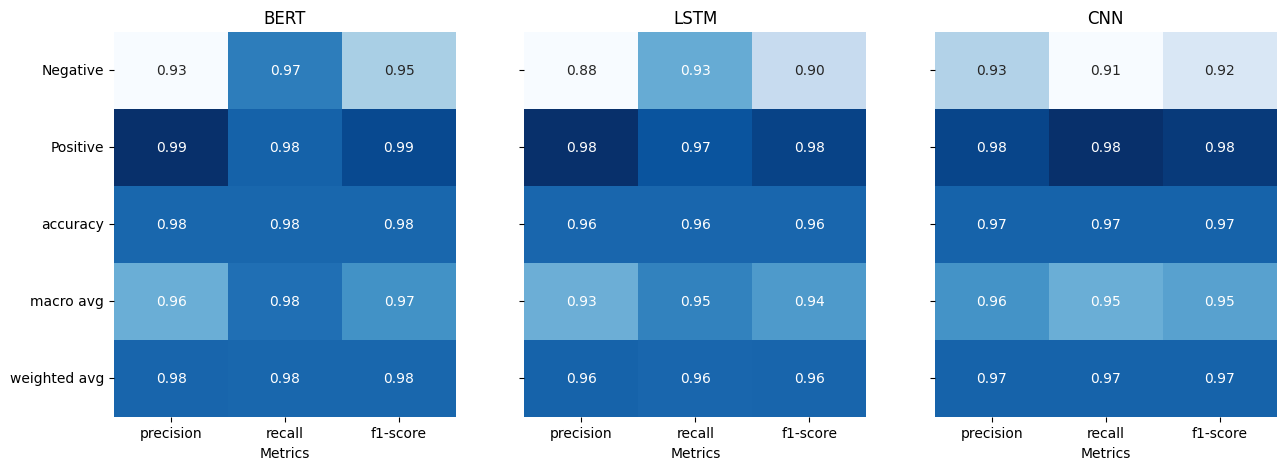

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),sharey=True)

report = classification_report(test_y, preds_BERT, target_names=['Negative', 'Positive'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[0])

axes[0].set_xlabel("Metrics")
#axes[0].set_ylabel("Class Labels")
axes[0].set_title("BERT")

report = classification_report(y_test, y_pred_LSTM, target_names=['Negative', 'Positive'], output_dict=True)
report_df_LSTM = pd.DataFrame(report).transpose()

report_df_LSTM.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df_LSTM, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])

axes[1].set_xlabel("Metrics")
#axes[1].set_ylabel("Class Labels")
axes[1].set_title("LSTM")


report = classification_report(y_test, y_pred_CNN, target_names=['Negative', 'Positive'], output_dict=True)
report_df_CNN = pd.DataFrame(report).transpose()

report_df_CNN.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df_CNN, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[2])

axes[2].set_xlabel("Metrics")
axes[2].set_title("CNN")

plt.savefig("/content/All 3 Classification report_TrainingData.png",dpi = 300, bbox_inches='tight')



NameError: ignored

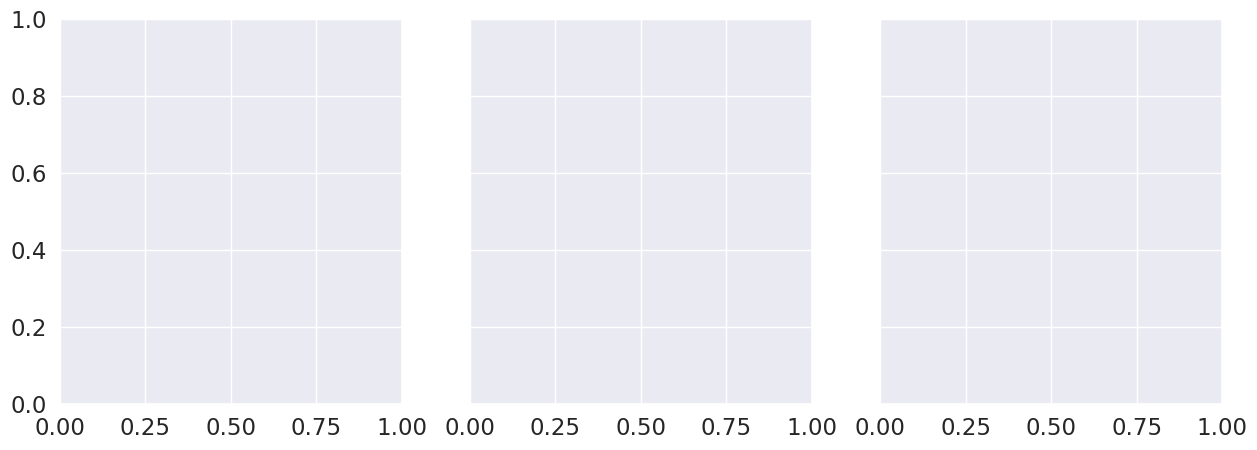

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),sharey=True)

report = classification_report(test_y, preds_BERT, target_names=['Negative', 'Positive'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[0])

axes[0].set_xlabel("Metrics")
#axes[0].set_ylabel("Class Labels")
axes[0].set_title("BERT")

report = classification_report(y_test, y_pred_LSTM, target_names=['Negative', 'Positive'], output_dict=True)
report_df_LSTM = pd.DataFrame(report).transpose()

report_df_LSTM.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df_LSTM, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])

axes[1].set_xlabel("Metrics")
#axes[1].set_ylabel("Class Labels")
axes[1].set_title("LSTM")


report = classification_report(y_test, y_pred_CNN, target_names=['Negative', 'Positive'], output_dict=True)
report_df_CNN = pd.DataFrame(report).transpose()

report_df_CNN.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df_CNN, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[2])

axes[2].set_xlabel("Metrics")
axes[2].set_title("CNN")

#plt.savefig("/content/All 3 Classification report_TrainingData.png",dpi = 300, bbox_inches='tight')





# Testing LSTM model on New Dataset

In [23]:
#Loading LSTM Model
from tensorflow.keras.models import load_model

lstm_model = load_model('/content/drive/MyDrive/lstm_model_acc_0.962.h5')

In [24]:
sample_reviews = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews['Srn'] = np.arange(sample_reviews.shape[0])

sample_reviews['reviews.actual_rating_sentiment'] = sample_reviews['reviews.rating'].apply(lambda x: 1 if x >=3  else 0)


sample_reviews.head(6)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,Srn,reviews.actual_rating_sentiment
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",0,1
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",1,1
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",2,1
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",3,1
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",4,1
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht...",5,1


In [25]:
# Pre-processing text

unseen_reviews = sample_reviews['reviews.text'] + sample_reviews['reviews.title']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [26]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [27]:
# Passing tokenised instance to the CNN model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

sample_reviews['Predicted Sentiments_lstm'] = np.round((unseen_sentiments*10)/2,1)


886/886 [==============================] - 65s 71ms/step


0.9469857405054356
0.7847581217946631
0.9509010619221525
0.9469857405054356
0.9487632241759112
0.9469857405054356
0.6021505376344086


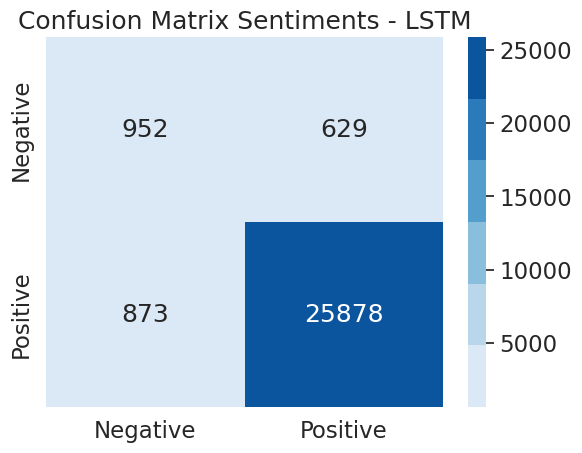

In [28]:
#New one
df_lstm_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_lstm']]

df_lstm_prediction['reviews.rating_sentiment'] = df_lstm_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['LSTM_Predicted.rating_sentiment'] = df_lstm_prediction['Predicted Sentiments_lstm'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['lstm_vs_actual'] = df_lstm_prediction['reviews.rating_sentiment'] == df_lstm_prediction['LSTM_Predicted.rating_sentiment']

df_lstm_prediction['reviews.actual_rating_sentiment'] = df_lstm_prediction['reviews.rating'].apply(lambda x: 1 if x >=3  else 0)
df_lstm_prediction['LSTM_rating.rating_sentiment'] = df_lstm_prediction['Predicted Sentiments_lstm'].apply(lambda x: 1 if x >=3  else 0)

sns.reset_orig()
#df_lstm_prediction.groupby('lstm_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

C_M_LSTM = confusion_matrix(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M_LSTM, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - LSTM")
#plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_LSTM_newdata = accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Balanced_accuracy_LSTM_newdata = balanced_accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Precision_LSTM_newdata = precision_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
Recall_LSTM_newdata = recall_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
F1_score_LSTM_newdata = f1_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted') #, average='macro'
sensitivity_LSTM_newdata = Recall_LSTM_newdata
specificity_LSTM_newdata =  C_M_LSTM[0][0] / (C_M_LSTM[0][0] + C_M_LSTM[0][1])

print(Accuracy_LSTM_newdata)
print(Balanced_accuracy_LSTM_newdata)
print(Precision_LSTM_newdata)
print(Recall_LSTM_newdata)
print(F1_score_LSTM_newdata)
print(sensitivity_LSTM_newdata)
print(specificity_LSTM_newdata)

#plt.savefig("confusion_matrix_NewData_LSTM.png", bbox_inches='tight')

In [ ]:
df_lstm_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_lstm']]

df_lstm_prediction.head(5)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_lstm
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,3.4
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,5.0
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0


0.9469857405054356
0.7847581217946631
0.9509010619221525
0.9469857405054356
0.9487632241759112
0.9469857405054356
0.6021505376344086


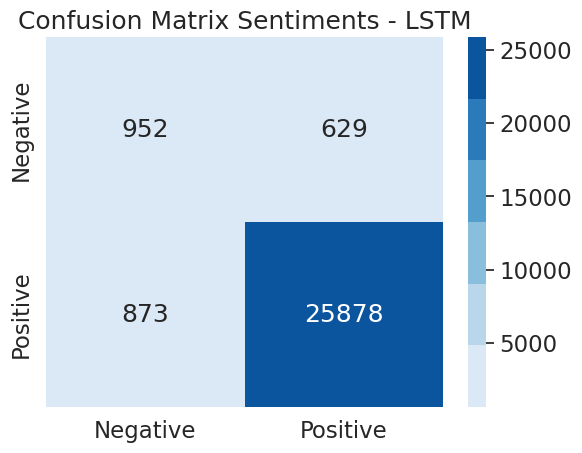

In [ ]:
#New one
df_lstm_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_lstm']]

df_lstm_prediction['reviews.rating_sentiment'] = df_lstm_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['LSTM_Predicted.rating_sentiment'] = df_lstm_prediction['Predicted Sentiments_lstm'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['lstm_vs_actual'] = df_lstm_prediction['reviews.rating_sentiment'] == df_lstm_prediction['LSTM_Predicted.rating_sentiment']

df_lstm_prediction['reviews.actual_rating_sentiment'] = df_lstm_prediction['reviews.rating'].apply(lambda x: 1 if x >=3  else 0)
df_lstm_prediction['LSTM_rating.rating_sentiment'] = df_lstm_prediction['Predicted Sentiments_lstm'].apply(lambda x: 1 if x >=3  else 0)

sns.reset_orig()
#df_lstm_prediction.groupby('lstm_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

C_M_LSTM = confusion_matrix(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M_LSTM, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - LSTM")
#plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_LSTM_newdata = accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Balanced_accuracy_LSTM_newdata = balanced_accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Precision_LSTM_newdata = precision_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
Recall_LSTM_newdata = recall_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
F1_score_LSTM_newdata = f1_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted') #, average='macro'
sensitivity_LSTM_newdata = Recall_LSTM_newdata
specificity_LSTM_newdata =  C_M_LSTM[0][0] / (C_M_LSTM[0][0] + C_M_LSTM[0][1])

print(Accuracy_LSTM_newdata)
print(Balanced_accuracy_LSTM_newdata)
print(Precision_LSTM_newdata)
print(Recall_LSTM_newdata)
print(F1_score_LSTM_newdata)
print(sensitivity_LSTM_newdata)
print(specificity_LSTM_newdata)

plt.savefig("confusion_matrix_NewData_LSTM.png", bbox_inches='tight')

In [ ]:
df_lstm_prediction['reviews.rating_sentiment'] = df_lstm_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['LSTM_Predicted.rating_sentiment'] = df_lstm_prediction['Predicted Sentiments_lstm'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_lstm_prediction['lstm_vs_actual'] = df_lstm_prediction['reviews.rating_sentiment'] == df_lstm_prediction['LSTM_Predicted.rating_sentiment']

df_lstm_prediction['reviews.actual_rating_sentiment'] = df_lstm_prediction['reviews.rating'].apply(lambda x: 1 if x >=3  else 0)
df_lstm_prediction['LSTM_rating.rating_sentiment'] = df_lstm_prediction['Predicted Sentiments_lstm'].apply(lambda x: 1 if x >=3  else 0)

df_lstm_prediction.head(5)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_lstm,reviews.rating_sentiment,LSTM_Predicted.rating_sentiment,lstm_vs_actual,reviews.actual_rating_sentiment,LSTM_rating.rating_sentiment
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.0,positive,negative,False,1,0
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,5.0,positive,positive,True,1,1
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0,positive,positive,True,1,1
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0,positive,positive,True,1,1
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0,positive,positive,True,1,1


<Axes: >

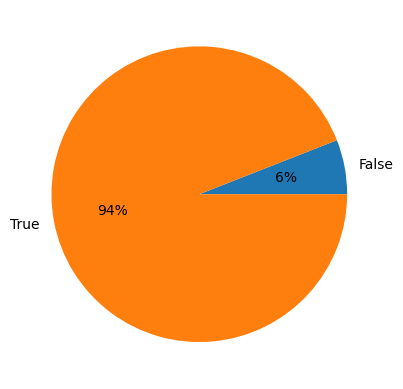

In [ ]:
sns.reset_orig()
df_lstm_prediction.groupby('lstm_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

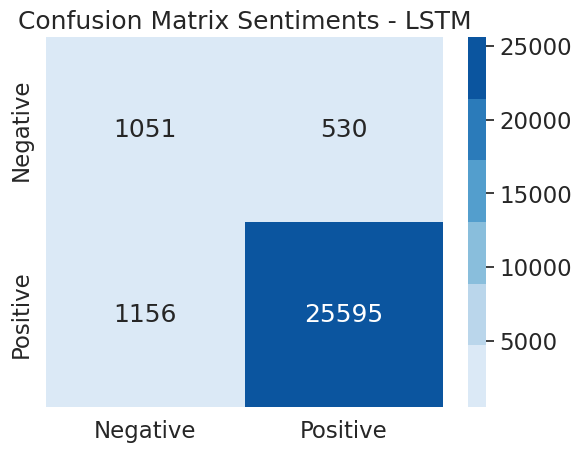

In [ ]:
C_M = confusion_matrix(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - LSTM")
#plt.show()

plt.savefig("confusion_matrix_NewData_LSTM.png", bbox_inches='tight')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_LSTM_newdata = accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Balanced_accuracy_LSTM_newdata = balanced_accuracy_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'])
Precision_LSTM_newdata = precision_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
Recall_LSTM_newdata = recall_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted')
F1_score_LSTM_newdata = f1_score(df_lstm_prediction['reviews.rating_sentiment'], df_lstm_prediction['LSTM_Predicted.rating_sentiment'],average = 'weighted') #, average='macro'
sensitivity_LSTM_newdata = Recall_LSTM_newdata
specificity_LSTM_newdata =  C_M[0][0] / (C_M[0][0] + C_M[0][1])


In [ ]:
print(Accuracy_LSTM_newdata)
print(Balanced_accuracy_LSTM_newdata)
print(Precision_LSTM_newdata)
print(Recall_LSTM_newdata)
print(F1_score_LSTM_newdata)
print(sensitivity_LSTM_newdata)
print(specificity_LSTM_newdata)

0.9404913172384582
0.8107778978203444
0.9516162481356331
0.9404913172384582
0.9450562191325741
0.9404913172384582
0.6647691334598356


# Testing CNN model on New Dataset

In [17]:
#Loading CNN Model
from tensorflow.keras.models import load_model

cnn_model = load_model('/content/drive/MyDrive/cnn_model_acc_0.969.h5')

In [18]:
sample_reviews = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews['Srn'] = np.arange(sample_reviews.shape[0])

sample_reviews.head(6)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,Srn
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",0
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",1
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",2
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",3
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",4
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht...",5


In [19]:
# Pre-processing text

unseen_reviews = sample_reviews['reviews.text'] + sample_reviews['reviews.title']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [20]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [21]:
# Passing tokenised instance to the CNN model for predictions
unseen_sentiments = cnn_model.predict(unseen_padded)

sample_reviews['Predicted Sentiments_cnn'] = np.round((unseen_sentiments*10)/2,1)


886/886 [==============================] - 19s 22ms/step


0.908831003811944
0.8044269319907671
0.9447128250622707
0.908831003811944
0.9227036180098163
0.908831003811944
0.6869070208728653


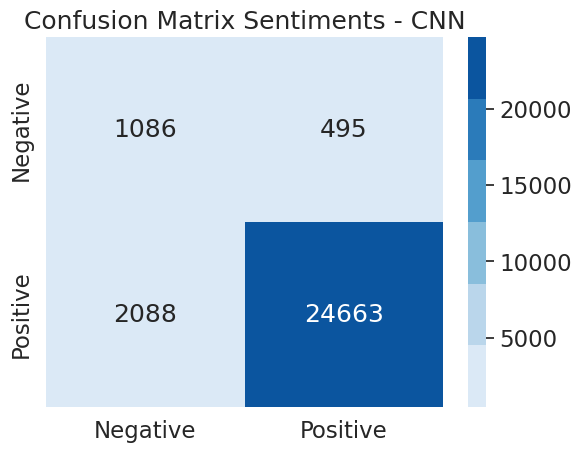

In [22]:
df_cnn_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_cnn']]

df_cnn_prediction['reviews.rating_sentiment'] = df_cnn_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['CNN_Predicted.rating_sentiment'] = df_cnn_prediction['Predicted Sentiments_cnn'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['cnn_vs_actual'] = df_cnn_prediction['reviews.rating_sentiment'] == df_cnn_prediction['CNN_Predicted.rating_sentiment']

df_cnn_prediction['reviews.actual_rating_sentiment'] = df_cnn_prediction['reviews.rating'].apply(lambda x: 1 if x >=3  else 0)
df_cnn_prediction['CNN_rating.rating_sentiment'] = df_cnn_prediction['Predicted Sentiments_cnn'].apply(lambda x: 1 if x >=3  else 0)

sns.reset_orig()
#df_cnn_prediction.groupby('cnn_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

C_M_CNN = confusion_matrix(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M_CNN, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - CNN")
#plt.show()
plt.savefig("confusion_matrix_NewData_CNN.png", bbox_inches='tight')

from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_CNN_newdata = accuracy_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])
Balanced_accuracy_CNN_newdata = balanced_accuracy_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])
Precision_CNN_newdata = precision_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted')
Recall_CNN_newdata = recall_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted')
F1_score_CNN_newdata = f1_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted') #, average='macro'
sensitivity_CNN_newdata = Recall_CNN_newdata
specificity_CNN_newdata =  C_M_CNN[0][0] / (C_M_CNN[0][0] + C_M_CNN[0][1])


print(Accuracy_CNN_newdata)
print(Balanced_accuracy_CNN_newdata)
print(Precision_CNN_newdata)
print(Recall_CNN_newdata)
print(F1_score_CNN_newdata)
print(sensitivity_CNN_newdata)
print(specificity_CNN_newdata)




In [ ]:
df_cnn_prediction = sample_reviews[['Srn','name','reviews.text','reviews.rating','Predicted Sentiments_cnn']]

df_cnn_prediction.head(5)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_cnn
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.5
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.9
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0


In [ ]:
df_cnn_prediction['reviews.rating_sentiment'] = df_cnn_prediction['reviews.rating'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['CNN_Predicted.rating_sentiment'] = df_cnn_prediction['Predicted Sentiments_cnn'].apply(lambda x: 'positive' if x >=3  else 'negative')
df_cnn_prediction['cnn_vs_actual'] = df_cnn_prediction['reviews.rating_sentiment'] == df_cnn_prediction['CNN_Predicted.rating_sentiment']

df_cnn_prediction['reviews.actual_rating_sentiment'] = df_cnn_prediction['reviews.rating'].apply(lambda x: 1 if x >=3  else 0)
df_cnn_prediction['CNN_rating.rating_sentiment'] = df_cnn_prediction['Predicted Sentiments_cnn'].apply(lambda x: 1 if x >=3  else 0)


df_cnn_prediction.head(5)

,Srn,name,reviews.text,reviews.rating,Predicted Sentiments_cnn,reviews.rating_sentiment,CNN_Predicted.rating_sentiment,cnn_vs_actual,reviews.actual_rating_sentiment,CNN_rating.rating_sentiment
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.5,positive,negative,False,1,0
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.9,positive,positive,True,1,1
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0,positive,positive,True,1,1
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0,positive,positive,True,1,1
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0,positive,positive,True,1,1


<Axes: >

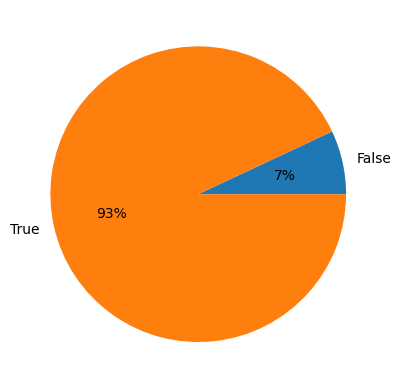

In [ ]:
sns.reset_orig()
df_cnn_prediction.groupby('cnn_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

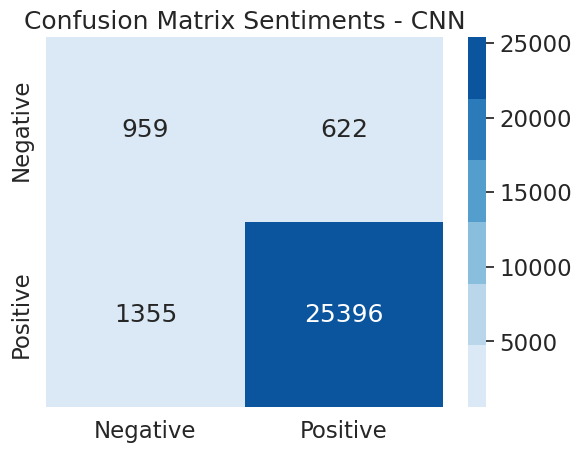

In [ ]:
C_M = confusion_matrix(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - CNN")
#plt.show()
plt.savefig("confusion_matrix_NewData_CNN.png", bbox_inches='tight')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_CNN_newdata = accuracy_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])
Balanced_accuracy_CNN_newdata = balanced_accuracy_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'])
Precision_CNN_newdata = precision_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted')
Recall_CNN_newdata = recall_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted')
F1_score_CNN_newdata = f1_score(df_cnn_prediction['reviews.rating_sentiment'], df_cnn_prediction['CNN_Predicted.rating_sentiment'],average = 'weighted') #, average='macro'
sensitivity_CNN_newdata = Recall_CNN_newdata
specificity_CNN_newdata =  C_M[0][0] / (C_M[0][0] + C_M[0][1])


print(Accuracy_CNN_newdata)
print(Balanced_accuracy_CNN_newdata)
print(Precision_CNN_newdata)
print(Recall_CNN_newdata)
print(F1_score_CNN_newdata)
print(sensitivity_CNN_newdata)
print(specificity_CNN_newdata)



0.9302202456586193
0.7779629015269571
0.9447513935368419
0.9302202456586193
0.936301525286603
0.9302202456586193
0.6065781151170145


#  Testing BERT model on New Dataset

In [ ]:
sample_reviews_BERT_unf = pd.read_csv("/content/drive/MyDrive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

sample_reviews_BERT_unf['BERT_sentiment'] = pd.Series()
sample_reviews_BERT_unf['Srn'] = np.arange(sample_reviews_BERT_unf.shape[0])

sample_reviews_BERT_unf['review_title'] = sample_reviews_BERT_unf['reviews.text'] +sample_reviews_BERT_unf['reviews.title']


In [ ]:
#30 mins execution time_Unfrozen layers
initial = 0
gap = 4000


while initial < len(sample_reviews_BERT)+1: #Running BERT algorithm on a batch of 3000 records to avoid memory issues
  end = initial + gap

  unseen_reviews = sample_reviews_BERT['review_title'][initial:end]

  unseen_processed = []
  for review in unseen_reviews:
    review = preprocess_text(review)
    unseen_processed.append(review)

  # tokenize and encode sequences in the test set
  MAX_LENGHT = 100 #As token count <= 100

  tokens_unseen = tokenizer.batch_encode_plus(
      unseen_processed,
      max_length = MAX_LENGHT,
      pad_to_max_length=True,
      truncation=True
  )

  unseen_seq = torch.tensor(tokens_unseen['input_ids'])
  unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

  with torch.no_grad():
    preds = model(unseen_seq, unseen_mask)
    preds = preds.detach().cpu().numpy()

  preds = np.argmax(preds, axis = 1)
  preds

  sample_reviews_BERT.loc[initial:end-1,'BERT_sentiment'] = preds #Predicting sentiment and updating df

  print(f"Rows {initial} - {end-1} affected")

  initial = end

Rows 0 - 3999 affected
Rows 4000 - 7999 affected
Rows 8000 - 11999 affected
Rows 12000 - 15999 affected
Rows 16000 - 19999 affected
Rows 20000 - 23999 affected
Rows 24000 - 27999 affected
Rows 28000 - 31999 affected


In [ ]:
#30 mins execution time_Unfrozen layers
initial = 0
gap = 4000


while initial < len(sample_reviews_BERT_unf)+1: #Running BERT algorithm on a batch of 3000 records to avoid memory issues
  end = initial + gap

  unseen_reviews = sample_reviews_BERT_unf['review_title'][initial:end]

  unseen_processed = []
  for review in unseen_reviews:
    review = preprocess_text(review)
    unseen_processed.append(review)

  # tokenize and encode sequences in the test set
  MAX_LENGHT = 100 #As token count <= 100

  tokens_unseen = tokenizer.batch_encode_plus(
      unseen_processed,
      max_length = MAX_LENGHT,
      pad_to_max_length=True,
      truncation=True
  )

  unseen_seq = torch.tensor(tokens_unseen['input_ids'])
  unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

  with torch.no_grad():
    preds_unf = model(unseen_seq, unseen_mask)
    preds_unf = preds_unf.detach().cpu().numpy()

  preds_unf = np.argmax(preds_unf, axis = 1)
  preds_unf

  sample_reviews_BERT_unf.loc[initial:end-1,'BERT_sentiment'] = preds_unf #Predicting sentiment and updating df

  print(f"Rows {initial} - {end-1} affected")

  initial = end

Rows 0 - 3999 affected
Rows 4000 - 7999 affected
Rows 8000 - 11999 affected
Rows 12000 - 15999 affected
Rows 16000 - 19999 affected
Rows 20000 - 23999 affected
Rows 24000 - 27999 affected
Rows 28000 - 31999 affected


In [ ]:
sample_reviews_BERT['Amazon_rating'] = sample_reviews_BERT['reviews.rating'].apply(lambda x: 1 if x >=3  else 0)
sample_reviews_BERT['BERT_vs_actual'] = sample_reviews_BERT['Amazon_rating'] == sample_reviews_BERT['BERT_sentiment']

<Axes: >

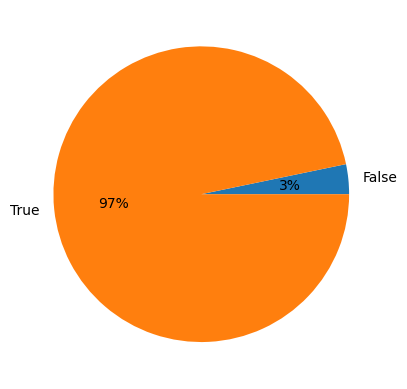

In [ ]:
#sns.reset_orig()
sample_reviews_BERT.groupby('BERT_vs_actual').size().plot(kind='pie', autopct='%1.0f%%')

In [ ]:
sample_reviews_BERT = pd.read_csv("/content/drive/MyDrive/Prediction_BERT.csv")

Text(0.5, 1.0, 'Confusion Matrix Sentiments - BERT')

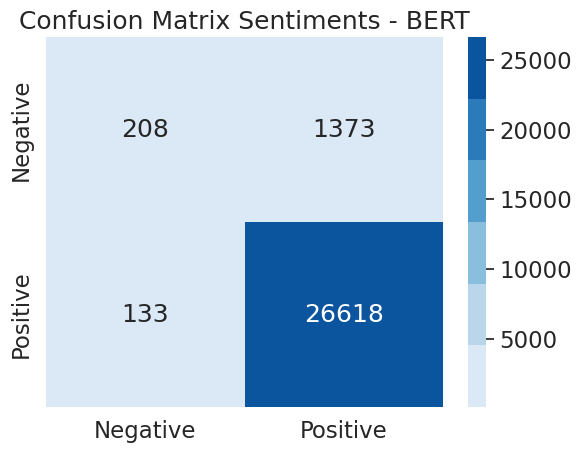

In [ ]:
#Frozen
C_M_BERT = confusion_matrix(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")


# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M_BERT, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

#plt.savefig("confusion_matrix_BERTNewData.png", bbox_inches='tight')


Text(0.5, 1.0, 'Confusion Matrix Sentiments - BERT')

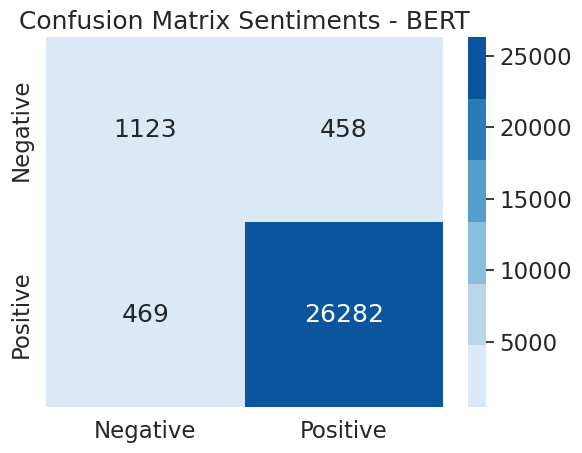

In [ ]:
#unrozen
C_M_BERT = confusion_matrix(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")


# Plot confusion matrix
sns.set(font_scale=1.5)
ax = sns.heatmap(C_M_BERT, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap)
ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

#plt.savefig("confusion_matrix_BERTNewData.png", bbox_inches='tight')


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_BERT_newdata = accuracy_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])
Balanced_accuracy_BERT_new_data = balanced_accuracy_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])
Precision_BERT_newdata = precision_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'],average = 'weighted')
Recall_BERT_newdata = recall_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'],average = 'weighted')
F1_score_BERT_newdata = f1_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'],average = 'weighted') #, average='macro'
sensitivity_BERT_newdata = Recall_BERT_newdata

print(Accuracy_BERT_newdata)
print(Balanced_accuracy_BERT_new_data)
print(Precision_BERT_newdata)
print(Recall_BERT_newdata)
print(F1_score_BERT_newdata)
print(sensitivity_BERT_newdata)


0.9672808132147395
0.8463889377736646
0.9673885419669762
0.9672808132147395
0.9673341636260742
0.9672808132147395


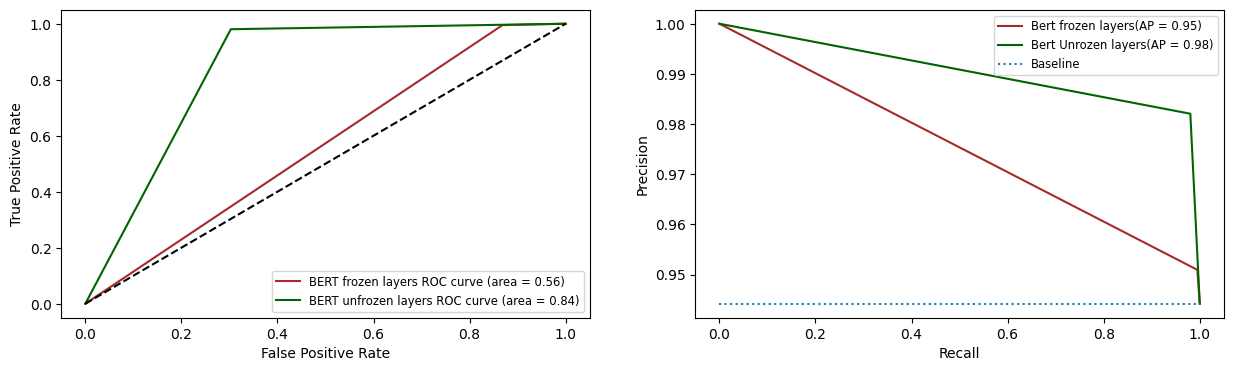

In [ ]:
#Frozen
sns.reset_orig()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

#preds_BERT = np.argmax(preds, axis = 1)

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

# Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr_unf, tpr_unf, thresholds_unf = roc_curve(sample_reviews_BERT_unf['Amazon_rating'], sample_reviews_BERT_unf['BERT_sentiment'])


# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Compute the area under the ROC curve (AUC)
roc_auc_unf = auc(fpr_unf, tpr_unf)


# Plot the ROC curve
axes[0].plot(fpr, tpr, color='brown', label='BERT frozen layers ROC curve (area = %0.2f)' % roc_auc)
axes[0].plot(fpr_unf, tpr_unf, color='darkgreen', label='BERT unfrozen layers ROC curve (area = %0.2f)' % roc_auc_unf)
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
#axes[0]..title('Receiver Operating Characteristic (ROC) BERT Training Data')
axes[0].legend(loc='best', fontsize='small')
#plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

avg_precision = average_precision_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

precision_unf, recall_unf, thresholds_unf = precision_recall_curve(sample_reviews_BERT_unf['Amazon_rating'], sample_reviews_BERT_unf['BERT_sentiment'])

avg_precision_unf = average_precision_score(sample_reviews_BERT_unf['Amazon_rating'], sample_reviews_BERT_unf['BERT_sentiment'])

sns.reset_orig()

baseline = sample_reviews_BERT_unf['Amazon_rating'][sample_reviews_BERT_unf['Amazon_rating']==1].shape[0] / sample_reviews_BERT_unf['Amazon_rating'].shape[0]


axes[1].plot(recall, precision, color='brown', label='Bert frozen layers(AP = %0.2f)' % avg_precision)
axes[1].plot(recall_unf, precision_unf, color='darkgreen', label='Bert Unrozen layers(AP = %0.2f)' % avg_precision_unf)
axes[1].plot([0, 1], [baseline, baseline], linestyle='dotted', label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
#axes[1].title('Precision-Recall Curve')
axes[1].legend(loc='best', fontsize='small')
#plt.show()

plt.savefig("BERT Frozen_Unfrozen New Data.png", bbox_inches='tight')


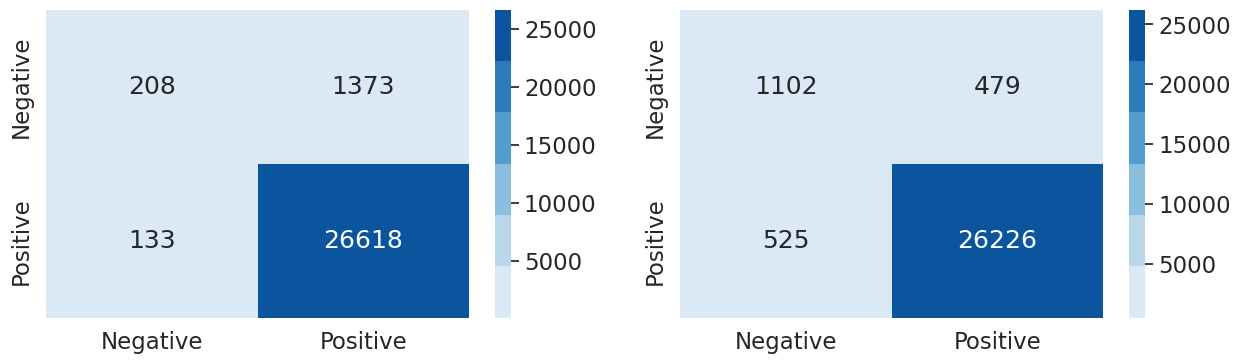

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

#h2_frozen
C_M = confusion_matrix(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

# Define labels
labels = {0: "Negative", 1: "Positive"}

# Define color palette
cmap = sns.color_palette("Blues")

# Plot confusion matrix
sns.set(font_scale=1.5)
sns.heatmap(C_M, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap,ax=axes[0])
#ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

#h3_1_unfrozen
C_M_unf = confusion_matrix(sample_reviews_BERT_unf['Amazon_rating'], sample_reviews_BERT_unf['BERT_sentiment'])


# Plot confusion matrix
sns.set(font_scale=1.5)
sns.heatmap(C_M_unf, annot=True, fmt="d", xticklabels=labels.values(), yticklabels=labels.values(), cmap=cmap,ax=axes[1])
#ax.set_title("Confusion Matrix Sentiments - BERT")
#plt.show()

#plt.savefig("confusion_matrix_TrainingData_BERT.png", bbox_inches='tight')


plt.savefig("confusion_matrix_NewData_BERT Frozen_vs_Unfrozen.png", bbox_inches='tight')


In [ ]:
#Frozen

from sklearn.metrics import precision_score, recall_score, f1_score,balanced_accuracy_score,confusion_matrix

Accuracy_BERT_newdata = accuracy_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])
Balanced_accuracy_BERT_new_data = balanced_accuracy_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])
Precision_BERT_newdata = precision_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'],average = 'weighted')
Recall_BERT_newdata = recall_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'],average = 'weighted')
F1_score_BERT_newdata = f1_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'],average = 'weighted') #, average='macro'
sensitivity_BERT_newdata = Recall_BERT_newdata
specificity_BERT_newdata =  C_M[0][0] / (C_M[0][0] + C_M[0][1])

print(Accuracy_BERT_newdata)
print(Balanced_accuracy_BERT_new_data)
print(Precision_BERT_newdata)
print(Recall_BERT_newdata)
print(F1_score_BERT_newdata)
print(sensitivity_BERT_newdata)
print(specificity_BERT_newdata)

0.9468445573909361
0.5632952627921409
0.931921060023885
0.9468445573909361
0.9302996712999899
0.9468445573909361
0.3423180592991914


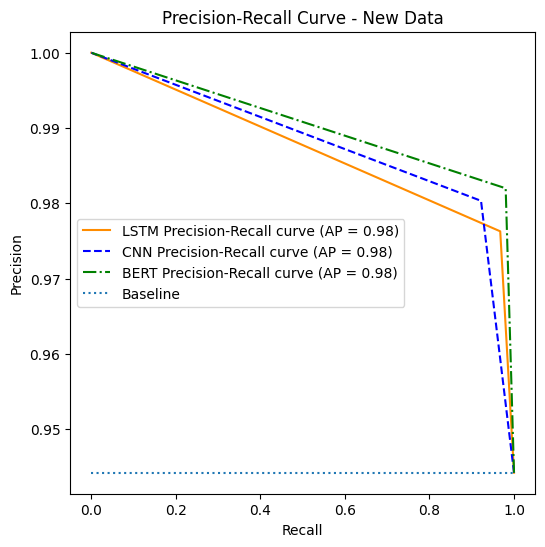

In [ ]:
sns.reset_orig()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'])

avg_precision_lstm = average_precision_score(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'])

precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'])

avg_precision_cnn = average_precision_score(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'])


precision_bert, recall_bert, thresholds_bert = precision_recall_curve(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

avg_precision_bert = average_precision_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_lstm, precision_lstm, color='darkorange', linestyle='-' , label='LSTM Precision-Recall curve (AP = %0.2f)' % avg_precision_lstm)
ax.plot(recall_cnn, precision_cnn, color='blue', linestyle='--' , label='CNN Precision-Recall curve (AP = %0.2f)' % avg_precision_cnn)
ax.plot(recall_bert, precision_bert, color='green', linestyle='-.' , label='BERT Precision-Recall curve (AP = %0.2f)' % avg_precision_bert)
baseline = df_cnn_prediction['reviews.actual_rating_sentiment'][df_cnn_prediction['reviews.actual_rating_sentiment']==1].shape[0] /  df_cnn_prediction['reviews.actual_rating_sentiment'].shape[0]
ax.plot([0, 1], [baseline, baseline], linestyle='dotted', label='Baseline')
#plt.plot([0, 1], [1, 0], color='navy', linestyle='--')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve - New Data')
ax.legend(loc='best')
#plt.show()

#plt.savefig("Precision-Recall Curve - All Model Performance on New Data.png", bbox_inches='tight')

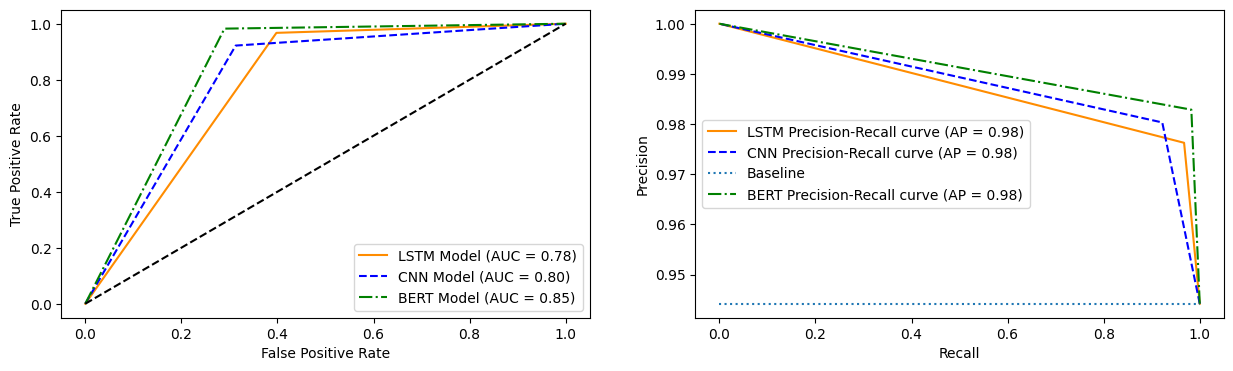

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.reset_orig()

# Compute the false positive rate (FPR) and true positive rate (TPR) for LSTM model
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'])
#fpr, tpr, thresholds = roc_curve(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'])

# Compute the false positive rate (FPR) and true positive rate (TPR) for CNN model
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'])
#fpr, tpr, thresholds = roc_curve(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'])


# Compute the false positive rate (FPR) and true positive rate (TPR) for BERT model
fpr_bert, tpr_bert, thresholds_bert = roc_curve(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])


# Compute the area under the ROC curve (AUC) for LSTM model
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# Compute the area under the ROC curve (AUC) for CNN model
roc_auc_bert = auc(fpr_bert, tpr_bert)

sns.reset_orig()

# Plot the ROC curves
axes[0].plot(fpr_lstm, tpr_lstm, color='darkorange', linestyle='-' , label='LSTM Model (AUC = %0.2f)' % roc_auc_lstm)
axes[0].plot(fpr_cnn, tpr_cnn, color='blue', linestyle='--' , label='CNN Model (AUC = %0.2f)' % roc_auc_cnn)
axes[0].plot(fpr_bert, tpr_bert, color='green', linestyle='-.' , label='BERT Model (AUC = %0.2f)' % roc_auc_bert)
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) - New Data')
axes[0].legend(loc='lower right')

sns.reset_orig()

precision_lstm, recall_lstm, thresholds_lstm = precision_recall_curve(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'])

avg_precision_lstm = average_precision_score(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'])

precision_cnn, recall_cnn, thresholds_cnn = precision_recall_curve(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'])

avg_precision_cnn = average_precision_score(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'])


precision_bert, recall_bert, thresholds_bert = precision_recall_curve(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])

avg_precision_bert = average_precision_score(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'])


axes[1].plot(recall_lstm, precision_lstm, color='darkorange', linestyle='-' , label='LSTM Precision-Recall curve (AP = %0.2f)' % avg_precision_lstm)
axes[1].plot(recall_cnn, precision_cnn, color='blue', linestyle='--' , label='CNN Precision-Recall curve (AP = %0.2f)' % avg_precision_cnn)
baseline = df_cnn_prediction['reviews.actual_rating_sentiment'][df_cnn_prediction['reviews.actual_rating_sentiment']==1].shape[0] /  df_cnn_prediction['reviews.actual_rating_sentiment'].shape[0]
axes[1].plot([0, 1], [baseline, baseline], linestyle='dotted', label='Baseline')
axes[1].plot(recall_bert, precision_bert, color='green', linestyle='-.' , label='BERT Precision-Recall curve (AP = %0.2f)' % avg_precision_bert)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='best')
#plt.show()

#plt.savefig("/content/All 3 ROC PR overview_NewData.png",dpi = 300, bbox_inches='tight')



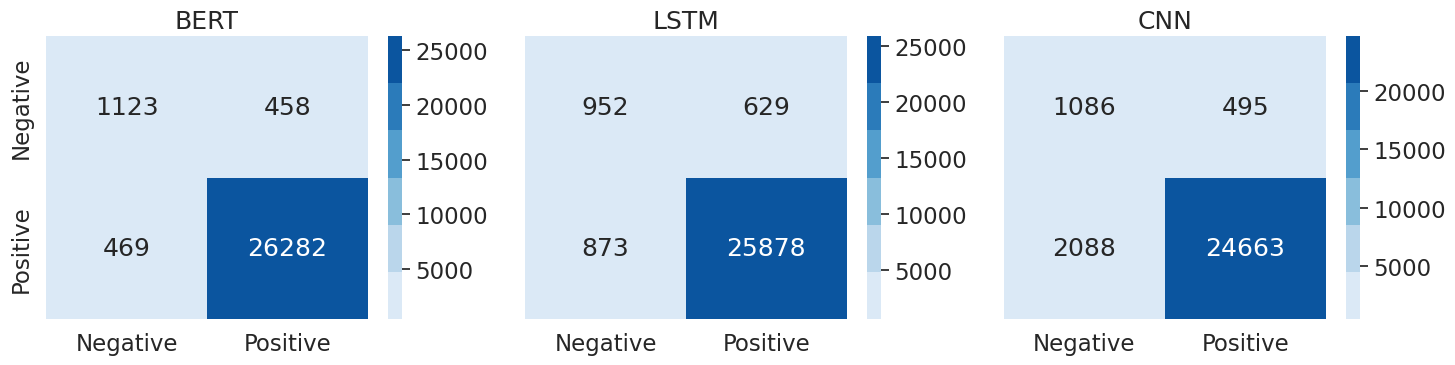

In [ ]:
cmap = sns.color_palette("Blues")
labels = ["Negative", "Positive"]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharey=True)

sns.heatmap(C_M_BERT, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            cmap=cmap, ax=axes[0])
axes[0].set_title('BERT')

sns.heatmap(C_M_LSTM, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            cmap=cmap, ax=axes[1])
axes[1].set_title('LSTM')

sns.heatmap(C_M_CNN, annot=True, fmt="d",
            xticklabels=labels, yticklabels=labels,
            cmap=cmap, ax=axes[2])
axes[2].set_title('CNN')

plt.tight_layout()

plt.savefig("/content/All 3 CM overview_NewData.png",dpi = 300, bbox_inches='tight')


In [ ]:
print('BERT')
print(classification_report(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'], target_names=['Negative', 'Positive']))

print('LSTM')
print(classification_report(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'], target_names=['Negative', 'Positive']))

print('CNN')
print(classification_report(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'], target_names=['Negative', 'Positive']))


BERT
              precision    recall  f1-score   support

    Negative       0.71      0.71      0.71      1581
    Positive       0.98      0.98      0.98     26751

    accuracy                           0.97     28332
   macro avg       0.84      0.85      0.85     28332
weighted avg       0.97      0.97      0.97     28332

LSTM
              precision    recall  f1-score   support

    Negative       0.52      0.60      0.56      1581
    Positive       0.98      0.97      0.97     26751

    accuracy                           0.95     28332
   macro avg       0.75      0.78      0.77     28332
weighted avg       0.95      0.95      0.95     28332

CNN
              precision    recall  f1-score   support

    Negative       0.34      0.69      0.46      1581
    Positive       0.98      0.92      0.95     26751

    accuracy                           0.91     28332
   macro avg       0.66      0.80      0.70     28332
weighted avg       0.94      0.91      0.92     28332



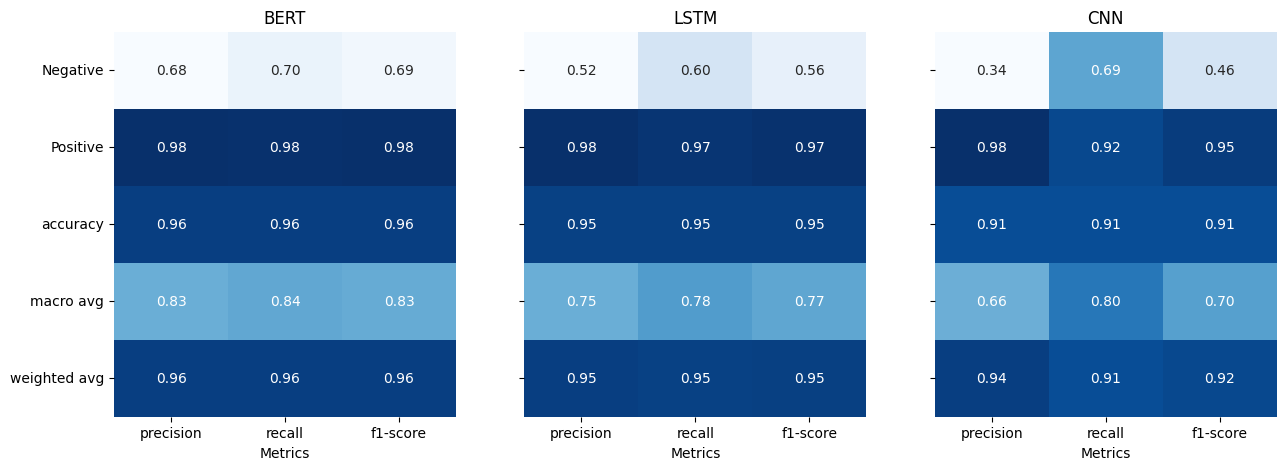

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5),sharey=True)

report = classification_report(sample_reviews_BERT['Amazon_rating'], sample_reviews_BERT['BERT_sentiment'], target_names=['Negative', 'Positive'], output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[0])

axes[0].set_xlabel("Metrics")
#axes[0].set_ylabel("Class Labels")
axes[0].set_title("BERT")

report = classification_report(df_lstm_prediction['reviews.actual_rating_sentiment'] , df_lstm_prediction['LSTM_rating.rating_sentiment'], target_names=['Negative', 'Positive'], output_dict=True)
report_df_LSTM = pd.DataFrame(report).transpose()

report_df_LSTM.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df_LSTM, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[1])

axes[1].set_xlabel("Metrics")
#axes[1].set_ylabel("Class Labels")
axes[1].set_title("LSTM")


report = classification_report(df_cnn_prediction['reviews.actual_rating_sentiment'] , df_cnn_prediction['CNN_rating.rating_sentiment'], target_names=['Negative', 'Positive'], output_dict=True)
report_df_CNN = pd.DataFrame(report).transpose()

report_df_CNN.drop('support', axis=1, inplace=True)

#axes[0].set_figure(figsize=(5, 5))
sns.heatmap(report_df_CNN, annot=True, fmt=".2f", cmap="Blues", cbar=False, ax=axes[2])

axes[2].set_xlabel("Metrics")
axes[2].set_title("CNN")

plt.savefig("/content/All 3 Classification report_NewData.png",dpi = 300, bbox_inches='tight')



In [ ]:
report_df_CNN

,precision,recall,f1-score
Negative,0.342155,0.686907,0.456782
Positive,0.980324,0.921947,0.950240
accuracy,0.908831,0.908831,0.908831
macro avg,0.661240,0.804427,0.703511
weighted avg,0.944713,0.908831,0.922704


# Merging Prediction based on LSTM_CNN for EDA

In [ ]:
df_CNN_LSTM = pd.merge(df_cnn_prediction,df_lstm_prediction,on='Srn')
df_CNN_LSTM_BERT = pd.merge(df_CNN_LSTM,sample_reviews,on='Srn')


In [ ]:
df_CNN_LSTM_BERT.to_csv("./drive/MyDrive/Prediction_LSTM_CNN_BERT.csv", sep=',', encoding='UTF-8')


In [ ]:
df_CNN_LSTM_BERT.shape

(28332, 47)

In [ ]:
df_CNN_LSTM_BERT_unq = df_CNN_LSTM_BERT.drop_duplicates()

df_CNN_LSTM_BERT_unq.shape

(28332, 47)

In [ ]:
reviews_processed = []
unseen_reviews = df_CNN_LSTM_BERT_unq['reviews.text']

for review in unseen_reviews:
  review = preprocess_text(review)
  reviews_processed.append(review)

df_CNN_LSTM_BERT_unq['reviews.numHelpful'] = df_CNN_LSTM_BERT_unq['reviews.numHelpful'].fillna(0)

df_CNN_LSTM_BERT_unq['reviews.processed'] = reviews_processed



In [ ]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

res = {}
for i, row in tqdm(df_CNN_LSTM_BERT_unq.iterrows(), total=len(df_CNN_LSTM_BERT_unq)):
    try:
      text = row['reviews.processed']
      myid = row['Srn']
      res[myid] = sia.polarity_scores(text)
    except:
      text = row['reviews.processed']
      myid = row['Srn']
      res[myid] = ""


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


  0%|          | 0/28332 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Srn'})
vaders = vaders.merge(df_CNN_LSTM_BERT_unq, how='left')
vaders.head(5)

,Srn,name_x,reviews.text_x,reviews.rating_x,Predicted Sentiments_cnn,reviews.rating_sentiment_x,CNN_Predicted.rating_sentiment,cnn_vs_actual,reviews.actual_rating_sentiment_x,CNN_rating.rating_sentiment,...,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,BERT_sentiment,review_title,Amazon_rating,BERT_vs_actual,reviews.processed
0,0,AmazonBasics AAA Performance Alkaline Batterie...,I order 3 of them and one of the item is bad q...,3,0.5,positive,negative,False,1,0,...,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...",0.0,I order 3 of them and one of the item is bad q...,1,False,i order of them and one of the item is bad qua...
1,1,AmazonBasics AAA Performance Alkaline Batterie...,Bulk is always the less expensive way to go fo...,4,4.9,positive,positive,True,1,1,...,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...",1.0,Bulk is always the less expensive way to go fo...,1,True,bulk is always the less expensive way to go fo...
2,2,AmazonBasics AAA Performance Alkaline Batterie...,Well they are not Duracell but for the price i...,5,5.0,positive,positive,True,1,1,...,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...",1.0,Well they are not Duracell but for the price i...,1,True,well they are not duracell but for the price a...
3,3,AmazonBasics AAA Performance Alkaline Batterie...,Seem to work as well as name brand batteries a...,5,5.0,positive,positive,True,1,1,...,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...",1.0,Seem to work as well as name brand batteries a...,1,True,seem to work as well as name brand batteries a...
4,4,AmazonBasics AAA Performance Alkaline Batterie...,These batteries are very long lasting the pric...,5,5.0,positive,positive,True,1,1,...,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...",1.0,These batteries are very long lasting the pric...,1,True,these batteries are very long lasting the pric...


In [ ]:
vaders.to_csv("./drive/MyDrive/All_predictions_vaders.csv", sep=',', encoding='UTF-8')
